In [1]:
%matplotlib inline
import torchfilter as tfilter
import torch.autograd.functional as F
import numpy as np
import pandas as pd
import pymap3d as pm
from matplotlib import pyplot as plt
import plotly.express as px
import torch
import torch.optim as optim
from tqdm.notebook import tqdm
from collections import namedtuple
import pytorch3d.transforms as tf
import xarray as xr
from torch.distributions.multivariate_normal import MultivariateNormal

/home/groups/gracegao/conda_envs/deep_gnss/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [2]:
import os, sys
sys.path.append('/scratch/users/shubhgup/1_18_winter/DDUncertaintyFilter/')
# sys.path.append('..')

from dynamics_models import *
from kf_measurement_models import *
from pf_measurement_models import *
from virtual_sensor_models import *
from utils import *
from filter_models import *

%load_ext autoreload
%autoreload 2

In [3]:
# Set origin position, orientation and timestamp
origin_lla, origin_ecef = get_reference_from_gt("22 18 04.31949  114 10 44.60559        3.472")   
origin_rpy = get_reference_rot("-1.7398149928   0.4409540487 -132.534729738")
origin_time = 1621218775.00

# origin_lla, origin_ecef = get_reference_from_gt("22 18 00.25350  114 10 47.25217        3.189") 
# origin_rpy = get_reference_rot("-0.6671978933   0.4780759843 137.9359508957")
# origin_time = 1621218838.00


# origin_lla, origin_ecef = get_reference_from_gt("22 17 51.54462  114 10 37.53472        2.433")  
# origin_rpy = get_reference_rot("-0.7491022101  -0.4393383077 -133.811686506")
# origin_time = 1621218900.00

# origin_lla, origin_ecef = get_reference_from_gt("22 17 49.70559  114 10 33.84846        3.084") 
# origin_rpy = get_reference_rot("1.5505269260   0.5986893297 -84.4024418600")
# origin_time = 1621218930.00

# Set endtime
end_time = origin_time + 400 #+ 777.0

In [4]:
# 1. Load ground truth data
gt_pos, gt_vel, gt_acc, gt_rot, gt_len = load_ground_truth_select("/oak/stanford/groups/gracegao/HKdataset/data_06_22_22/UrbanNav_TST_GT_raw.txt", origin_lla)
# 2. Load dd data
dd_data = load_dd_data(origin_lla, origin_ecef, "/oak/stanford/groups/gracegao/Shubh/10_6_cleanup/KITTI360_Processing/TRI_KF/save_data/")
# 3. Load IMU data
imu_data = xr.DataArray(pd.read_csv("/oak/stanford/groups/gracegao/HKdataset/data_06_22_22/xsense_imu_medium_urban1.csv"))
# 4. Parse IMU data
timestamp, or_quat, or_cov, ang_vel, ang_vel_cov, lin_acc, lin_acc_cov = parse_imu_data(imu_data)
# 5. Load VO data
vo_data = prepare_vo_data("/scratch/users/shubhgup/1_18_winter/Left_features/2d3dmatches")
# 6. Load GPS Ambiguity and cycle slip data
# ints_data = get_ints_data()
# mixed_data = get_cycle_slip_data()

In [5]:
# Generate index converters
imu_to_gt_idx, imu_to_gnss_idx, utc_to_imu_idx, gt_to_imu_idx, utc_to_gt_idx, utc_to_gnss_idx, gt_idx_to_utc, gnss_idx_to_utc = gen_idx_converters(timestamp)
imu_to_vo_idx, vo_to_imu_idx = imu_to_vo_idx_from_timestamp(timestamp, vo_data)

In [6]:
# Generate ground truth deltas
gt_pos_delta, gt_rot_delta = gen_gt_deltas(gt_pos, gt_rot, imu_to_gt_idx, vo_to_imu_idx)

# Filter Code

In [90]:
N_dim, state_dim = create_state_dim(0, 16)

T_start, T, IMU_rate_div = get_imu_idx(origin_time, end_time, utc_to_imu_idx, 100)

dynamics_model = PosVelQuatBiasModel()

inter_const_bias = inter_const_bias_tensor(dd_data)

kf_measurement_model = init_filter_measurement_model(dd_data, N_dim, IMU_VO_DD_MeasurementModel)
# pf_measurement_model = init_filter_measurement_model(dd_data, N_dim, GNSSPFMeasurementModel_IMU_DD_VO)

reset_filter = gen_reset_function(state_dim, timestamp, gt_pos, gt_vel, gt_rot, imu_to_gt_idx, IMU_rate_div, T_start)

test_filter = AsyncExtendedKalmanFilter(
    dynamics_model=dynamics_model, # Initialise the filter with the dynamic model
    measurement_model=kf_measurement_model, # Initialise the filter with the measurement model
    )

test_filter

AsyncExtendedKalmanFilter(
  (dynamics_model): PosVelQuatBiasModel(
    (pos_vel_model): PosVelModel(
      (pos_model): XYZModel()
      (vel_model): XYZModel()
    )
    (quat_model): QuaternionOrientationModel()
    (imu_bias_model): IMUBiasModel()
  )
  (measurement_model): IMU_VO_DD_MeasurementModel(
    (imu_model): IMUMeasurementModel()
    (vo_base_model): VOMeasurementModel()
    (vo_model): VOLandmarkMeasurementModel()
    (gnss_model): GNSSDDKFMeasurementModel()
  )
)

In [91]:
# Reset filter
t = T_start + IMU_rate_div
recorded_data = reset_filter(test_filter, t - IMU_rate_div)
recorded_data

{'dynamics_parameters': [{'pos_x_std': 5.109628,
   'pos_y_std': 5.436571,
   'pos_z_std': 0.001,
   'vel_x_std': 0.313416,
   'vel_y_std': 2.103889,
   'vel_z_std': 0.0001,
   'r_std': 0.0017453292519943296,
   'p_std': 0.0017453292519943296,
   'y_std': 0.2617993877991494,
   'acc_bias_std': 0.01,
   'gyr_bias_std': 0.05235987755982989}],
 'observation_parameters': [{'r_std': 0.001,
   'p_std': 0.0012,
   'y_std': 0.236015,
   'imu_robust_threshold': 0.7,
   'speed_std': 0.703181,
   'speed_scale': 0.6006,
   'speed_robust_threshold': 5.0,
   'prange_std': 3.139834,
   'prange_robust_threshold': 3.0,
   'carrier_std': 10.0}],
 'controls': [],
 'imu_observation': [],
 'gnss_observation': [],
 'gnss_observation_context': [],
 'last_update_timestamp': 1621218775.302105,
 'last_update_imu': -1,
 'last_update_vo': -1,
 'last_update_gnss': -1,
 'last_update_gt': -1,
 'estimated_states': []}

In [92]:
def run_timestep(t, recorded_data):
    
    dyn_parameters = recorded_data['dynamics_parameters'][-1]
    obs_parameters = recorded_data['observation_parameters'][-1]
    
    # Load IMU data
    timestamp_t, or_quat_t, or_cov_t, ang_vel_t, ang_vel_cov_t, lin_acc_t, lin_acc_cov_t = timestamp[t], or_quat[t], or_cov[t], ang_vel[t], ang_vel_cov[t], lin_acc[t], lin_acc_cov[t]

    # Compute time difference
    prev_timestamp = recorded_data['last_update_timestamp']
    dt = (timestamp_t - prev_timestamp)
    prev_timestamp = timestamp_t

    test_filter.update_dynamics(
            dt=dt, 
            pos_x_std=torch.tensor(dyn_parameters['pos_x_std']), 
            pos_y_std=torch.tensor(dyn_parameters['pos_y_std']), 
            pos_z_std=torch.tensor(dyn_parameters['pos_z_std']), 
            vel_x_std=torch.tensor(dyn_parameters['vel_x_std']), 
            vel_y_std=torch.tensor(dyn_parameters['vel_y_std']), 
            vel_z_std=torch.tensor(dyn_parameters['vel_z_std']), 
            r_std=torch.tensor(dyn_parameters['r_std']), 
            p_std=torch.tensor(dyn_parameters['p_std']), 
            y_std=torch.tensor(dyn_parameters['y_std']), 
            acc_bias_std=torch.tensor(dyn_parameters['acc_bias_std']), 
            gyr_bias_std=torch.tensor(dyn_parameters['gyr_bias_std'])
        )


    estimated_state = imu_predict_and_update(
        test_filter, 
        lin_acc_t, ang_vel_t, or_quat_t, 
        torch.tensor(obs_parameters['r_std']), torch.tensor(obs_parameters['p_std']), torch.tensor(obs_parameters['y_std']),
        torch.tensor(obs_parameters['imu_robust_threshold']),
        m_estimation=False
        )
    
    # VO data
    vo_idx = recorded_data['last_update_vo']
    new_vo_idx = imu_to_vo_idx(t)
    if new_vo_idx > vo_idx:
        vo_idx = new_vo_idx

        # Load VO data
        landmark_3d, pixel_2d, K, ransac_R, ransac_t = load_vo_data(vo_idx, vo_data, size=50)
        
        estimated_state = vo_update(
            test_filter, estimated_state,
            landmark_3d, pixel_2d, K, ransac_R, ransac_t, 
            torch.tensor(obs_parameters['speed_std']), torch.tensor(obs_parameters['speed_scale']),
            torch.tensor(obs_parameters['speed_robust_threshold']),
            vel_scaling_factor=IMU_rate_div/27/dt,
            m_estimation=False
            )
    
    # GNSS data
    dd_idx = recorded_data['last_update_gnss']
    new_dd_idx = imu_to_gnss_idx(t)
    if new_dd_idx > dd_idx:
        dd_idx = new_dd_idx

        # Load GNSS observables
        rover_code, base_code, rover_carr, base_carr, rover_cnos, satpos, idx_code_mask, idx_carr_mask = to_tensor(read_gnss_data(dd_data, dd_idx, 'mixed'))

        gnss_observation, idx_code_mask, idx_carr_mask, ref = calc_gnss_observation(rover_code, base_code, rover_carr, base_carr, satpos, idx_code_mask, idx_carr_mask, ref=None, include_carrier=False)

        estimated_state = gnss_update(
            test_filter, estimated_state, 
            gnss_observation, satpos, ref, inter_const_bias, idx_code_mask, idx_carr_mask, 
            torch.tensor(obs_parameters['prange_std']), torch.tensor(obs_parameters['carrier_std']), 
            torch.tensor(obs_parameters['prange_robust_threshold']),
            m_estimation=True
            )
    
    # Update context
    recorded_data['last_update_timestamp'] = prev_timestamp
    recorded_data['last_update_imu'] = t
    recorded_data['last_update_vo'] = vo_idx
    recorded_data['estimated_states'].append(estimated_state)
    
    return recorded_data
# estimated_state[:, 3:6].detach().numpy() - gt_pos_delta(vo_idx), gt_pos[imu_to_gt_idx(t)] - estimated_state[0, :3].detach().numpy(), eul2quat(torch.tensor(gt_rot[imu_to_gt_idx(t)])) - estimated_state[0, 6:10].detach().numpy()

In [93]:
recorded_data = reset_filter(test_filter, T_start)
with torch.no_grad():
    for t in tqdm(range(T_start+IMU_rate_div, T, IMU_rate_div)):
        recorded_data = run_timestep(t, recorded_data)

  0%|          | 0/1597 [00:00<?, ?it/s]

residuals tensor([[ 0.8541, -0.1611,  0.1880,  0.8857]])
residuals tensor([[ 0.8541, -0.1611,  0.1880,  0.8857],
        [ 0.8541, -0.1611,  0.1880,  0.8857],
        [ 0.8541, -0.1611,  0.1880,  0.8857],
        [ 0.8541, -0.1611,  0.1880,  0.8857]])
residuals tensor([[-0.1793,  0.0223, -0.0177, -0.1780]])
residuals tensor([[-0.1793,  0.0223, -0.0177, -0.1780],
        [-0.1793,  0.0223, -0.0177, -0.1780],
        [-0.1793,  0.0223, -0.0177, -0.1780],
        [-0.1793,  0.0223, -0.0177, -0.1780]])
residuals tensor([[0.0364, 0.0383, 0.0267, 0.0346]])
residuals tensor([[0.0364, 0.0383, 0.0267, 0.0346],
        [0.0364, 0.0383, 0.0267, 0.0346],
        [0.0364, 0.0383, 0.0267, 0.0346],
        [0.0364, 0.0383, 0.0267, 0.0346]])
residuals tensor([[-0.0387, -0.0160, -0.0523, -0.0370]])
residuals tensor([[-0.0387, -0.0160, -0.0523, -0.0370],
        [-0.0387, -0.0160, -0.0523, -0.0370],
        [-0.0387, -0.0160, -0.0523, -0.0370],
        [-0.0387, -0.0160, -0.0523, -0.0370]])
residuals te

residuals tensor([[-0.0005,  0.0753, -0.0207, -0.0034]])
residuals tensor([[-0.0005,  0.0753, -0.0207, -0.0034],
        [-0.0005,  0.0753, -0.0207, -0.0034],
        [-0.0005,  0.0753, -0.0207, -0.0034],
        [-0.0005,  0.0753, -0.0207, -0.0034]])
residuals tensor([[ 0.0572, -0.0962, -0.0482,  0.0615]])
residuals tensor([[ 0.0572, -0.0962, -0.0482,  0.0615],
        [ 0.0572, -0.0962, -0.0482,  0.0615],
        [ 0.0572, -0.0962, -0.0482,  0.0615],
        [ 0.0572, -0.0962, -0.0482,  0.0615]])
residuals tensor([[ 0.0189, -0.0487,  0.0951,  0.0196]])
residuals tensor([[ 0.0189, -0.0487,  0.0951,  0.0196],
        [ 0.0189, -0.0487,  0.0951,  0.0196],
        [ 0.0189, -0.0487,  0.0951,  0.0196],
        [ 0.0189, -0.0487,  0.0951,  0.0196]])
residuals tensor([[ 0.1134, -0.0263, -0.1082,  0.1156]])
residuals tensor([[ 0.1134, -0.0263, -0.1082,  0.1156],
        [ 0.1134, -0.0263, -0.1082,  0.1156],
        [ 0.1134, -0.0263, -0.1082,  0.1156],
        [ 0.1134, -0.0263, -0.1082,  0.

residuals tensor([[ 1.0271e+00, -3.9462e-02, -3.2628e-02,  1.6862e+02]])
residuals tensor([[ 1.0271e+00, -3.9462e-02, -3.2628e-02,  1.6862e+02],
        [ 1.0271e+00, -3.9462e-02, -3.2628e-02,  1.6862e+02],
        [ 1.0271e+00, -3.9462e-02, -3.2628e-02,  1.6862e+02],
        [ 1.0271e+00, -3.9462e-02, -3.2628e-02,  1.6862e+02]])
residuals tensor([[ 9.5250e-01, -4.1098e-02, -1.5167e-01,  1.7228e+02]])
residuals tensor([[ 9.5250e-01, -4.1098e-02, -1.5167e-01,  1.7228e+02],
        [ 9.5250e-01, -4.1098e-02, -1.5167e-01,  1.7228e+02],
        [ 9.5250e-01, -4.1098e-02, -1.5167e-01,  1.7228e+02],
        [ 9.5250e-01, -4.1098e-02, -1.5167e-01,  1.7228e+02]])
residuals tensor([[ 9.2932e-01, -9.5951e-02,  2.0519e-03,  1.7750e+02]])
residuals tensor([[ 9.2932e-01, -9.5951e-02,  2.0519e-03,  1.7750e+02],
        [ 9.2932e-01, -9.5951e-02,  2.0519e-03,  1.7750e+02],
        [ 9.2932e-01, -9.5951e-02,  2.0519e-03,  1.7750e+02],
        [ 9.2932e-01, -9.5951e-02,  2.0519e-03,  1.7750e+02]])
resi

residuals tensor([[ 2.9989e-01, -1.7572e-02, -1.9873e-03,  1.6233e+02]])
residuals tensor([[ 2.9989e-01, -1.7572e-02, -1.9873e-03,  1.6233e+02],
        [ 2.9989e-01, -1.7572e-02, -1.9873e-03,  1.6233e+02],
        [ 2.9989e-01, -1.7572e-02, -1.9873e-03,  1.6233e+02],
        [ 2.9989e-01, -1.7572e-02, -1.9873e-03,  1.6233e+02]])
residuals tensor([[ 2.9844e-01, -2.3583e-02, -1.3249e-01,  1.6210e+02]])
residuals tensor([[ 2.9844e-01, -2.3583e-02, -1.3249e-01,  1.6210e+02],
        [ 2.9844e-01, -2.3583e-02, -1.3249e-01,  1.6210e+02],
        [ 2.9844e-01, -2.3583e-02, -1.3249e-01,  1.6210e+02],
        [ 2.9844e-01, -2.3583e-02, -1.3249e-01,  1.6210e+02]])
residuals tensor([[ 3.4192e-01, -1.5708e-02, -1.6899e-02,  1.6309e+02]])
residuals tensor([[ 3.4192e-01, -1.5708e-02, -1.6899e-02,  1.6309e+02],
        [ 3.4192e-01, -1.5708e-02, -1.6899e-02,  1.6309e+02],
        [ 3.4192e-01, -1.5708e-02, -1.6899e-02,  1.6309e+02],
        [ 3.4192e-01, -1.5708e-02, -1.6899e-02,  1.6309e+02]])
resi

residuals tensor([[ 7.5611e-02, -3.4793e-02, -4.2778e-02,  1.5938e+02],
        [ 7.5611e-02, -3.4793e-02, -4.2778e-02,  1.5938e+02],
        [ 7.5611e-02, -3.4793e-02, -4.2778e-02,  1.5938e+02],
        [ 7.5611e-02, -3.4793e-02, -4.2778e-02,  1.5938e+02]])
residuals tensor([[ 8.1925e-02, -4.1780e-02,  1.9898e-01,  1.6040e+02]])
residuals tensor([[ 8.1925e-02, -4.1780e-02,  1.9898e-01,  1.6040e+02],
        [ 8.1925e-02, -4.1780e-02,  1.9898e-01,  1.6040e+02],
        [ 8.1925e-02, -4.1780e-02,  1.9898e-01,  1.6040e+02],
        [ 8.1925e-02, -4.1780e-02,  1.9898e-01,  1.6040e+02]])
residuals tensor([[ 7.3838e-02, -1.2894e-01,  2.8833e-01,  1.6098e+02]])
residuals tensor([[ 7.3838e-02, -1.2894e-01,  2.8833e-01,  1.6098e+02],
        [ 7.3838e-02, -1.2894e-01,  2.8833e-01,  1.6098e+02],
        [ 7.3838e-02, -1.2894e-01,  2.8833e-01,  1.6098e+02],
        [ 7.3838e-02, -1.2894e-01,  2.8833e-01,  1.6098e+02]])
residuals tensor([[ 3.4103e-02, -7.2707e-03,  1.1900e-01,  1.6025e+02]])
resi

residuals tensor([[-7.4100e-04,  2.9473e-02,  4.0365e-02,  1.5809e+02]])
residuals tensor([[-7.4100e-04,  2.9473e-02,  4.0365e-02,  1.5809e+02],
        [-7.4100e-04,  2.9473e-02,  4.0365e-02,  1.5809e+02],
        [-7.4100e-04,  2.9473e-02,  4.0365e-02,  1.5809e+02],
        [-7.4100e-04,  2.9473e-02,  4.0365e-02,  1.5809e+02]])
residuals tensor([[-4.0307e-02,  5.5936e-02, -4.5618e-02,  1.5746e+02]])
residuals tensor([[-4.0307e-02,  5.5936e-02, -4.5618e-02,  1.5746e+02],
        [-4.0307e-02,  5.5936e-02, -4.5618e-02,  1.5746e+02],
        [-4.0307e-02,  5.5936e-02, -4.5618e-02,  1.5746e+02],
        [-4.0307e-02,  5.5936e-02, -4.5618e-02,  1.5746e+02]])
residuals tensor([[-1.1618e-02,  5.8273e-02, -2.9362e-02,  1.5787e+02]])
residuals tensor([[-1.1618e-02,  5.8273e-02, -2.9362e-02,  1.5787e+02],
        [-1.1618e-02,  5.8273e-02, -2.9362e-02,  1.5787e+02],
        [-1.1618e-02,  5.8273e-02, -2.9362e-02,  1.5787e+02],
        [-1.1618e-02,  5.8273e-02, -2.9362e-02,  1.5787e+02]])
resi

residuals tensor([[ 2.5523e-02, -3.4069e-03, -6.7219e-02,  1.5733e+02]])
residuals tensor([[ 2.5523e-02, -3.4069e-03, -6.7219e-02,  1.5733e+02],
        [ 2.5523e-02, -3.4069e-03, -6.7219e-02,  1.5733e+02],
        [ 2.5523e-02, -3.4069e-03, -6.7219e-02,  1.5733e+02],
        [ 2.5523e-02, -3.4069e-03, -6.7219e-02,  1.5733e+02]])
residuals tensor([[-1.7627e-02,  3.5350e-03,  5.0914e-02,  1.5658e+02]])
residuals tensor([[-1.7627e-02,  3.5350e-03,  5.0914e-02,  1.5658e+02],
        [-1.7627e-02,  3.5350e-03,  5.0914e-02,  1.5658e+02],
        [-1.7627e-02,  3.5350e-03,  5.0914e-02,  1.5658e+02],
        [-1.7627e-02,  3.5350e-03,  5.0914e-02,  1.5658e+02]])
residuals tensor([[-2.3085e-02,  5.3334e-02, -3.6568e-02,  1.5645e+02]])
residuals tensor([[-2.3085e-02,  5.3334e-02, -3.6568e-02,  1.5645e+02],
        [-2.3085e-02,  5.3334e-02, -3.6568e-02,  1.5645e+02],
        [-2.3085e-02,  5.3334e-02, -3.6568e-02,  1.5645e+02],
        [-2.3085e-02,  5.3334e-02, -3.6568e-02,  1.5645e+02]])
resi

residuals tensor([[-7.2254e-02,  3.4135e-02, -1.0031e-02,  1.5588e+02]])
residuals tensor([[-7.2254e-02,  3.4135e-02, -1.0031e-02,  1.5588e+02],
        [-7.2254e-02,  3.4135e-02, -1.0031e-02,  1.5588e+02],
        [-7.2254e-02,  3.4135e-02, -1.0031e-02,  1.5588e+02],
        [-7.2254e-02,  3.4135e-02, -1.0031e-02,  1.5588e+02]])
residuals tensor([[-9.3527e-03,  8.9573e-02, -1.3731e-01,  1.5672e+02]])
residuals tensor([[-9.3527e-03,  8.9573e-02, -1.3731e-01,  1.5672e+02],
        [-9.3527e-03,  8.9573e-02, -1.3731e-01,  1.5672e+02],
        [-9.3527e-03,  8.9573e-02, -1.3731e-01,  1.5672e+02],
        [-9.3527e-03,  8.9573e-02, -1.3731e-01,  1.5672e+02]])
residuals tensor([[1.6170e-02, 3.5756e-03, 4.2120e-02, 1.5718e+02]])
residuals tensor([[1.6170e-02, 3.5756e-03, 4.2120e-02, 1.5718e+02],
        [1.6170e-02, 3.5756e-03, 4.2120e-02, 1.5718e+02],
        [1.6170e-02, 3.5756e-03, 4.2120e-02, 1.5718e+02],
        [1.6170e-02, 3.5756e-03, 4.2120e-02, 1.5718e+02]])
residuals tensor([[-3.98

residuals tensor([[ 3.0208e-03, -3.2576e-02,  4.8445e-02,  1.5241e+02],
        [ 3.0208e-03, -3.2576e-02,  4.8445e-02,  1.5241e+02],
        [ 3.0208e-03, -3.2576e-02,  4.8445e-02,  1.5241e+02],
        [ 3.0208e-03, -3.2576e-02,  4.8445e-02,  1.5241e+02]])
residuals tensor([[ 6.5728e-03, -1.1096e-01,  1.5285e-01,  1.5220e+02]])
residuals tensor([[ 6.5728e-03, -1.1096e-01,  1.5285e-01,  1.5220e+02],
        [ 6.5728e-03, -1.1096e-01,  1.5285e-01,  1.5220e+02],
        [ 6.5728e-03, -1.1096e-01,  1.5285e-01,  1.5220e+02],
        [ 6.5728e-03, -1.1096e-01,  1.5285e-01,  1.5220e+02]])
residuals tensor([[ 2.0935e-02, -9.0630e-02,  1.3385e-01,  1.5228e+02]])
residuals tensor([[ 2.0935e-02, -9.0630e-02,  1.3385e-01,  1.5228e+02],
        [ 2.0935e-02, -9.0630e-02,  1.3385e-01,  1.5228e+02],
        [ 2.0935e-02, -9.0630e-02,  1.3385e-01,  1.5228e+02],
        [ 2.0935e-02, -9.0630e-02,  1.3385e-01,  1.5228e+02]])
residuals tensor([[ 5.4743e-04, -5.6980e-02,  8.9184e-02,  1.5196e+02]])
resi

residuals tensor([[ 1.8884e-02, -7.7372e-02,  9.8788e-02,  1.4804e+02]])
residuals tensor([[ 1.8884e-02, -7.7372e-02,  9.8788e-02,  1.4804e+02],
        [ 1.8884e-02, -7.7372e-02,  9.8788e-02,  1.4804e+02],
        [ 1.8884e-02, -7.7372e-02,  9.8788e-02,  1.4804e+02],
        [ 1.8884e-02, -7.7372e-02,  9.8788e-02,  1.4804e+02]])
residuals tensor([[-3.9398e-02, -1.7051e-01,  1.6159e-01,  1.4702e+02]])
residuals tensor([[-3.9398e-02, -1.7051e-01,  1.6159e-01,  1.4702e+02],
        [-3.9398e-02, -1.7051e-01,  1.6159e-01,  1.4702e+02],
        [-3.9398e-02, -1.7051e-01,  1.6159e-01,  1.4702e+02],
        [-3.9398e-02, -1.7051e-01,  1.6159e-01,  1.4702e+02]])
residuals tensor([[-6.2041e-02, -1.1296e-01,  7.2452e-02,  1.4652e+02]])
residuals tensor([[-6.2041e-02, -1.1296e-01,  7.2452e-02,  1.4652e+02],
        [-6.2041e-02, -1.1296e-01,  7.2452e-02,  1.4652e+02],
        [-6.2041e-02, -1.1296e-01,  7.2452e-02,  1.4652e+02],
        [-6.2041e-02, -1.1296e-01,  7.2452e-02,  1.4652e+02]])
resi

residuals tensor([[ 7.3463e-03, -1.0509e-02, -3.8619e-02,  1.4650e+02]])
residuals tensor([[ 7.3463e-03, -1.0509e-02, -3.8619e-02,  1.4650e+02],
        [ 7.3463e-03, -1.0509e-02, -3.8619e-02,  1.4650e+02],
        [ 7.3463e-03, -1.0509e-02, -3.8619e-02,  1.4650e+02],
        [ 7.3463e-03, -1.0509e-02, -3.8619e-02,  1.4650e+02]])
residuals tensor([[-8.4279e-05,  1.9462e-03,  2.8059e-01,  1.4712e+02]])
residuals tensor([[-8.4279e-05,  1.9462e-03,  2.8059e-01,  1.4712e+02],
        [-8.4279e-05,  1.9462e-03,  2.8059e-01,  1.4712e+02],
        [-8.4279e-05,  1.9462e-03,  2.8059e-01,  1.4712e+02],
        [-8.4279e-05,  1.9462e-03,  2.8059e-01,  1.4712e+02]])
residuals tensor([[3.2257e-02, 4.4480e-02, 4.6689e-02, 1.4890e+02]])
residuals tensor([[3.2257e-02, 4.4480e-02, 4.6689e-02, 1.4890e+02],
        [3.2257e-02, 4.4480e-02, 4.6689e-02, 1.4890e+02],
        [3.2257e-02, 4.4480e-02, 4.6689e-02, 1.4890e+02],
        [3.2257e-02, 4.4480e-02, 4.6689e-02, 1.4890e+02]])
residuals tensor([[ 8.34

residuals tensor([[ 2.7172e-01,  8.6872e-03, -3.3357e-02,  2.3166e+02]])
residuals tensor([[ 2.7172e-01,  8.6872e-03, -3.3357e-02,  2.3166e+02],
        [ 2.7172e-01,  8.6872e-03, -3.3357e-02,  2.3166e+02],
        [ 2.7172e-01,  8.6872e-03, -3.3357e-02,  2.3166e+02],
        [ 2.7172e-01,  8.6872e-03, -3.3357e-02,  2.3166e+02]])
residuals tensor([[ 2.9049e-01, -6.4792e-04,  1.4394e-02,  2.7496e+02]])
residuals tensor([[ 2.9049e-01, -6.4792e-04,  1.4394e-02,  2.7496e+02],
        [ 2.9049e-01, -6.4792e-04,  1.4394e-02,  2.7496e+02],
        [ 2.9049e-01, -6.4792e-04,  1.4394e-02,  2.7496e+02],
        [ 2.9049e-01, -6.4792e-04,  1.4394e-02,  2.7496e+02]])
residuals tensor([[ 2.2518e-01,  8.8554e-02, -1.4868e-01,  3.4890e+02]])
residuals tensor([[ 2.2518e-01,  8.8554e-02, -1.4868e-01,  3.4890e+02],
        [ 2.2518e-01,  8.8554e-02, -1.4868e-01,  3.4890e+02],
        [ 2.2518e-01,  8.8554e-02, -1.4868e-01,  3.4890e+02],
        [ 2.2518e-01,  8.8554e-02, -1.4868e-01,  3.4890e+02]])
resi

residuals tensor([[25.2395, -0.0913, -0.1053, -0.0499]])
residuals tensor([[25.2395, -0.0913, -0.1053, -0.0499],
        [25.2395, -0.0913, -0.1053, -0.0499],
        [25.2395, -0.0913, -0.1053, -0.0499],
        [25.2395, -0.0913, -0.1053, -0.0499]])
residuals tensor([[25.0693,  0.0476,  0.0939, -0.0271]])
residuals tensor([[25.0693,  0.0476,  0.0939, -0.0271],
        [25.0693,  0.0476,  0.0939, -0.0271],
        [25.0693,  0.0476,  0.0939, -0.0271],
        [25.0693,  0.0476,  0.0939, -0.0271]])
residuals tensor([[ 2.5026e+01,  6.7089e-02, -1.4400e-04, -3.9275e-02]])
residuals tensor([[ 2.5026e+01,  6.7089e-02, -1.4400e-04, -3.9275e-02],
        [ 2.5026e+01,  6.7089e-02, -1.4400e-04, -3.9275e-02],
        [ 2.5026e+01,  6.7089e-02, -1.4400e-04, -3.9275e-02],
        [ 2.5026e+01,  6.7089e-02, -1.4400e-04, -3.9275e-02]])
residuals tensor([[24.9862,  0.1131,  0.0642, -0.0285]])
residuals tensor([[24.9862,  0.1131,  0.0642, -0.0285],
        [24.9862,  0.1131,  0.0642, -0.0285],
     

residuals tensor([[ 2.3753e+01, -1.4164e-01, -1.3478e-01, -6.2251e-03]])
residuals tensor([[ 2.3753e+01, -1.4164e-01, -1.3478e-01, -6.2251e-03],
        [ 2.3753e+01, -1.4164e-01, -1.3478e-01, -6.2251e-03],
        [ 2.3753e+01, -1.4164e-01, -1.3478e-01, -6.2251e-03],
        [ 2.3753e+01, -1.4164e-01, -1.3478e-01, -6.2251e-03]])
residuals tensor([[23.7004,  0.0773,  0.1047,  0.0241]])
residuals tensor([[23.7004,  0.0773,  0.1047,  0.0241],
        [23.7004,  0.0773,  0.1047,  0.0241],
        [23.7004,  0.0773,  0.1047,  0.0241],
        [23.7004,  0.0773,  0.1047,  0.0241]])
residuals tensor([[ 2.3840e+01,  1.4470e-01, -1.0765e-02, -4.1087e-02]])
residuals tensor([[ 2.3840e+01,  1.4470e-01, -1.0765e-02, -4.1087e-02],
        [ 2.3840e+01,  1.4470e-01, -1.0765e-02, -4.1087e-02],
        [ 2.3840e+01,  1.4470e-01, -1.0765e-02, -4.1087e-02],
        [ 2.3840e+01,  1.4470e-01, -1.0765e-02, -4.1087e-02]])
residuals tensor([[ 2.3937e+01, -2.1638e-01, -3.2285e-01,  2.5377e-03]])
residuals t

residuals tensor([[ 2.5339e+01, -1.0773e-02, -5.5612e-03,  2.7416e-04]])
residuals tensor([[ 2.5339e+01, -1.0773e-02, -5.5612e-03,  2.7416e-04],
        [ 2.5339e+01, -1.0773e-02, -5.5612e-03,  2.7416e-04],
        [ 2.5339e+01, -1.0773e-02, -5.5612e-03,  2.7416e-04],
        [ 2.5339e+01, -1.0773e-02, -5.5612e-03,  2.7416e-04]])
residuals tensor([[25.2069,  0.0852, -0.2687, -0.0519]])
residuals tensor([[25.2069,  0.0852, -0.2687, -0.0519],
        [25.2069,  0.0852, -0.2687, -0.0519],
        [25.2069,  0.0852, -0.2687, -0.0519],
        [25.2069,  0.0852, -0.2687, -0.0519]])
residuals tensor([[ 2.4841e+01, -6.4266e-02,  1.9408e-02,  9.0072e-02]])
residuals tensor([[ 2.4841e+01, -6.4266e-02,  1.9408e-02,  9.0072e-02],
        [ 2.4841e+01, -6.4266e-02,  1.9408e-02,  9.0072e-02],
        [ 2.4841e+01, -6.4266e-02,  1.9408e-02,  9.0072e-02],
        [ 2.4841e+01, -6.4266e-02,  1.9408e-02,  9.0072e-02]])
residuals tensor([[24.2713,  0.1362, -0.4538,  0.3074]])
residuals tensor([[24.2713,

residuals tensor([[2.3206e+01, 5.3075e-02, 1.6028e-01, 1.1470e-02]])
residuals tensor([[2.3206e+01, 5.3075e-02, 1.6028e-01, 1.1470e-02],
        [2.3206e+01, 5.3075e-02, 1.6028e-01, 1.1470e-02],
        [2.3206e+01, 5.3075e-02, 1.6028e-01, 1.1470e-02],
        [2.3206e+01, 5.3075e-02, 1.6028e-01, 1.1470e-02]])
residuals tensor([[23.1395,  0.0415,  0.0589, -0.0315]])
residuals tensor([[23.1395,  0.0415,  0.0589, -0.0315],
        [23.1395,  0.0415,  0.0589, -0.0315],
        [23.1395,  0.0415,  0.0589, -0.0315],
        [23.1395,  0.0415,  0.0589, -0.0315]])
residuals tensor([[ 2.2816e+01, -1.4758e-01, -5.7706e-02, -1.7205e-03]])
residuals tensor([[ 2.2816e+01, -1.4758e-01, -5.7706e-02, -1.7205e-03],
        [ 2.2816e+01, -1.4758e-01, -5.7706e-02, -1.7205e-03],
        [ 2.2816e+01, -1.4758e-01, -5.7706e-02, -1.7205e-03],
        [ 2.2816e+01, -1.4758e-01, -5.7706e-02, -1.7205e-03]])
residuals tensor([[22.3348,  0.0395,  0.1056, -0.0433]])
residuals tensor([[22.3348,  0.0395,  0.1056, -

residuals tensor([[ 2.4465e+01, -1.4540e-01,  1.0198e-02, -1.2638e-02]])
residuals tensor([[ 2.4465e+01, -1.4540e-01,  1.0198e-02, -1.2638e-02],
        [ 2.4465e+01, -1.4540e-01,  1.0198e-02, -1.2638e-02],
        [ 2.4465e+01, -1.4540e-01,  1.0198e-02, -1.2638e-02],
        [ 2.4465e+01, -1.4540e-01,  1.0198e-02, -1.2638e-02]])
residuals tensor([[24.4703,  0.2694, -0.1380, -0.0762]])
residuals tensor([[24.4703,  0.2694, -0.1380, -0.0762],
        [24.4703,  0.2694, -0.1380, -0.0762],
        [24.4703,  0.2694, -0.1380, -0.0762],
        [24.4703,  0.2694, -0.1380, -0.0762]])
residuals tensor([[24.4962, -0.1810, -0.2943, -0.1602]])
residuals tensor([[24.4962, -0.1810, -0.2943, -0.1602],
        [24.4962, -0.1810, -0.2943, -0.1602],
        [24.4962, -0.1810, -0.2943, -0.1602],
        [24.4962, -0.1810, -0.2943, -0.1602]])
residuals tensor([[ 2.4265e+01,  1.4896e-01, -5.3531e-02, -2.0330e-02]])
residuals tensor([[ 2.4265e+01,  1.4896e-01, -5.3531e-02, -2.0330e-02],
        [ 2.4265e+0

residuals tensor([[23.1378,  0.2476,  0.5626,  0.0280]])
residuals tensor([[23.1378,  0.2476,  0.5626,  0.0280],
        [23.1378,  0.2476,  0.5626,  0.0280],
        [23.1378,  0.2476,  0.5626,  0.0280],
        [23.1378,  0.2476,  0.5626,  0.0280]])
residuals tensor([[ 2.3026e+01, -3.9303e-01,  1.6030e-01, -3.0115e-03]])
residuals tensor([[ 2.3026e+01, -3.9303e-01,  1.6030e-01, -3.0115e-03],
        [ 2.3026e+01, -3.9303e-01,  1.6030e-01, -3.0115e-03],
        [ 2.3026e+01, -3.9303e-01,  1.6030e-01, -3.0115e-03],
        [ 2.3026e+01, -3.9303e-01,  1.6030e-01, -3.0115e-03]])
residuals tensor([[22.8192, -0.0665,  0.2185,  0.0262]])
residuals tensor([[22.8192, -0.0665,  0.2185,  0.0262],
        [22.8192, -0.0665,  0.2185,  0.0262],
        [22.8192, -0.0665,  0.2185,  0.0262],
        [22.8192, -0.0665,  0.2185,  0.0262]])
residuals tensor([[22.9144,  0.0700, -0.1493, -0.0962]])
residuals tensor([[22.9144,  0.0700, -0.1493, -0.0962],
        [22.9144,  0.0700, -0.1493, -0.0962],
     

residuals tensor([[32.1014,  0.0791,  0.3850, -0.0490]])
residuals tensor([[32.1014,  0.0791,  0.3850, -0.0490],
        [32.1014,  0.0791,  0.3850, -0.0490],
        [32.1014,  0.0791,  0.3850, -0.0490],
        [32.1014,  0.0791,  0.3850, -0.0490]])
residuals tensor([[ 3.3677e+01, -8.9885e-03,  2.3552e-01, -1.0734e-02]])
residuals tensor([[ 3.3677e+01, -8.9885e-03,  2.3552e-01, -1.0734e-02],
        [ 3.3677e+01, -8.9885e-03,  2.3552e-01, -1.0734e-02],
        [ 3.3677e+01, -8.9885e-03,  2.3552e-01, -1.0734e-02],
        [ 3.3677e+01, -8.9885e-03,  2.3552e-01, -1.0734e-02]])
residuals tensor([[35.3804, -0.1450,  0.1516,  0.0392]])
residuals tensor([[35.3804, -0.1450,  0.1516,  0.0392],
        [35.3804, -0.1450,  0.1516,  0.0392],
        [35.3804, -0.1450,  0.1516,  0.0392],
        [35.3804, -0.1450,  0.1516,  0.0392]])
residuals tensor([[37.2070, -0.0773,  0.1016,  0.0424]])
residuals tensor([[37.2070, -0.0773,  0.1016,  0.0424],
        [37.2070, -0.0773,  0.1016,  0.0424],
     

residuals tensor([[ 6.1318e+01,  1.3872e-01,  1.1148e-01, -3.6645e-02]])
residuals tensor([[ 6.1318e+01,  1.3872e-01,  1.1148e-01, -3.6645e-02],
        [ 6.1318e+01,  1.3872e-01,  1.1148e-01, -3.6645e-02],
        [ 6.1318e+01,  1.3872e-01,  1.1148e-01, -3.6645e-02],
        [ 6.1318e+01,  1.3872e-01,  1.1148e-01, -3.6645e-02]])
residuals tensor([[ 6.1271e+01,  3.6670e-02, -2.5813e-02, -3.0275e-02]])
residuals tensor([[ 6.1271e+01,  3.6670e-02, -2.5813e-02, -3.0275e-02],
        [ 6.1271e+01,  3.6670e-02, -2.5813e-02, -3.0275e-02],
        [ 6.1271e+01,  3.6670e-02, -2.5813e-02, -3.0275e-02],
        [ 6.1271e+01,  3.6670e-02, -2.5813e-02, -3.0275e-02]])
residuals tensor([[ 6.1443e+01,  3.7076e-02, -5.6069e-02, -9.7936e-02]])
residuals tensor([[ 6.1443e+01,  3.7076e-02, -5.6069e-02, -9.7936e-02],
        [ 6.1443e+01,  3.7076e-02, -5.6069e-02, -9.7936e-02],
        [ 6.1443e+01,  3.7076e-02, -5.6069e-02, -9.7936e-02],
        [ 6.1443e+01,  3.7076e-02, -5.6069e-02, -9.7936e-02]])
resi

residuals tensor([[ 6.1244e+01,  7.5135e-02,  4.8168e-02, -2.9858e-02]])
residuals tensor([[ 6.1244e+01,  7.5135e-02,  4.8168e-02, -2.9858e-02],
        [ 6.1244e+01,  7.5135e-02,  4.8168e-02, -2.9858e-02],
        [ 6.1244e+01,  7.5135e-02,  4.8168e-02, -2.9858e-02],
        [ 6.1244e+01,  7.5135e-02,  4.8168e-02, -2.9858e-02]])
residuals tensor([[ 6.1265e+01,  1.1941e-02, -7.1032e-02, -4.6803e-02]])
residuals tensor([[ 6.1265e+01,  1.1941e-02, -7.1032e-02, -4.6803e-02],
        [ 6.1265e+01,  1.1941e-02, -7.1032e-02, -4.6803e-02],
        [ 6.1265e+01,  1.1941e-02, -7.1032e-02, -4.6803e-02],
        [ 6.1265e+01,  1.1941e-02, -7.1032e-02, -4.6803e-02]])
residuals tensor([[ 6.1044e+01, -2.0936e-02, -1.8371e-02,  1.4174e-02]])
residuals tensor([[ 6.1044e+01, -2.0936e-02, -1.8371e-02,  1.4174e-02],
        [ 6.1044e+01, -2.0936e-02, -1.8371e-02,  1.4174e-02],
        [ 6.1044e+01, -2.0936e-02, -1.8371e-02,  1.4174e-02],
        [ 6.1044e+01, -2.0936e-02, -1.8371e-02,  1.4174e-02]])
resi

residuals tensor([[ 6.0988e+01,  5.0062e-02, -1.0057e-01, -5.9877e-02]])
residuals tensor([[ 6.0988e+01,  5.0062e-02, -1.0057e-01, -5.9877e-02],
        [ 6.0988e+01,  5.0062e-02, -1.0057e-01, -5.9877e-02],
        [ 6.0988e+01,  5.0062e-02, -1.0057e-01, -5.9877e-02],
        [ 6.0988e+01,  5.0062e-02, -1.0057e-01, -5.9877e-02]])
residuals tensor([[ 6.0712e+01,  8.2086e-02, -2.0930e-04,  2.3640e-02]])
residuals tensor([[ 6.0712e+01,  8.2086e-02, -2.0930e-04,  2.3640e-02],
        [ 6.0712e+01,  8.2086e-02, -2.0930e-04,  2.3640e-02],
        [ 6.0712e+01,  8.2086e-02, -2.0930e-04,  2.3640e-02],
        [ 6.0712e+01,  8.2086e-02, -2.0930e-04,  2.3640e-02]])
residuals tensor([[ 6.0845e+01,  3.1153e-02,  1.0551e-01, -1.4509e-02]])
residuals tensor([[ 6.0845e+01,  3.1153e-02,  1.0551e-01, -1.4509e-02],
        [ 6.0845e+01,  3.1153e-02,  1.0551e-01, -1.4509e-02],
        [ 6.0845e+01,  3.1153e-02,  1.0551e-01, -1.4509e-02],
        [ 6.0845e+01,  3.1153e-02,  1.0551e-01, -1.4509e-02]])
resi

residuals tensor([[6.0758e+01, 1.0366e-02, 4.6224e-02, 1.2519e-02]])
residuals tensor([[6.0758e+01, 1.0366e-02, 4.6224e-02, 1.2519e-02],
        [6.0758e+01, 1.0366e-02, 4.6224e-02, 1.2519e-02],
        [6.0758e+01, 1.0366e-02, 4.6224e-02, 1.2519e-02],
        [6.0758e+01, 1.0366e-02, 4.6224e-02, 1.2519e-02]])
residuals tensor([[ 6.0830e+01, -2.5391e-02,  4.5426e-02, -8.5482e-03]])
residuals tensor([[ 6.0830e+01, -2.5391e-02,  4.5426e-02, -8.5482e-03],
        [ 6.0830e+01, -2.5391e-02,  4.5426e-02, -8.5482e-03],
        [ 6.0830e+01, -2.5391e-02,  4.5426e-02, -8.5482e-03],
        [ 6.0830e+01, -2.5391e-02,  4.5426e-02, -8.5482e-03]])
residuals tensor([[ 6.0860e+01, -3.8945e-02,  1.0591e-02, -1.4754e-02]])
residuals tensor([[ 6.0860e+01, -3.8945e-02,  1.0591e-02, -1.4754e-02],
        [ 6.0860e+01, -3.8945e-02,  1.0591e-02, -1.4754e-02],
        [ 6.0860e+01, -3.8945e-02,  1.0591e-02, -1.4754e-02],
        [ 6.0860e+01, -3.8945e-02,  1.0591e-02, -1.4754e-02]])
residuals tensor([[ 6.08

residuals tensor([[6.0768e+01, 1.7923e-02, 7.5347e-03, 7.6999e-03]])
residuals tensor([[6.0768e+01, 1.7923e-02, 7.5347e-03, 7.6999e-03],
        [6.0768e+01, 1.7923e-02, 7.5347e-03, 7.6999e-03],
        [6.0768e+01, 1.7923e-02, 7.5347e-03, 7.6999e-03],
        [6.0768e+01, 1.7923e-02, 7.5347e-03, 7.6999e-03]])
residuals tensor([[ 6.0764e+01, -8.2029e-02, -7.4628e-02, -5.6468e-03]])
residuals tensor([[ 6.0764e+01, -8.2029e-02, -7.4628e-02, -5.6468e-03],
        [ 6.0764e+01, -8.2029e-02, -7.4628e-02, -5.6468e-03],
        [ 6.0764e+01, -8.2029e-02, -7.4628e-02, -5.6468e-03],
        [ 6.0764e+01, -8.2029e-02, -7.4628e-02, -5.6468e-03]])
residuals tensor([[ 6.0777e+01, -1.1786e-01, -7.8849e-02, -5.4978e-03]])
residuals tensor([[ 6.0777e+01, -1.1786e-01, -7.8849e-02, -5.4978e-03],
        [ 6.0777e+01, -1.1786e-01, -7.8849e-02, -5.4978e-03],
        [ 6.0777e+01, -1.1786e-01, -7.8849e-02, -5.4978e-03],
        [ 6.0777e+01, -1.1786e-01, -7.8849e-02, -5.4978e-03]])
residuals tensor([[ 6.06

residuals tensor([[ 6.0930e+01, -3.8861e-02, -1.6630e-01, -7.1658e-02]])
residuals tensor([[ 6.0930e+01, -3.8861e-02, -1.6630e-01, -7.1658e-02],
        [ 6.0930e+01, -3.8861e-02, -1.6630e-01, -7.1658e-02],
        [ 6.0930e+01, -3.8861e-02, -1.6630e-01, -7.1658e-02],
        [ 6.0930e+01, -3.8861e-02, -1.6630e-01, -7.1658e-02]])
residuals tensor([[ 6.0932e+01,  3.2933e-02, -2.7620e-02, -5.6591e-02]])
residuals tensor([[ 6.0932e+01,  3.2933e-02, -2.7620e-02, -5.6591e-02],
        [ 6.0932e+01,  3.2933e-02, -2.7620e-02, -5.6591e-02],
        [ 6.0932e+01,  3.2933e-02, -2.7620e-02, -5.6591e-02],
        [ 6.0932e+01,  3.2933e-02, -2.7620e-02, -5.6591e-02]])
residuals tensor([[ 6.0986e+01,  4.0665e-02,  2.0990e-02, -8.1122e-02]])
residuals tensor([[ 6.0986e+01,  4.0665e-02,  2.0990e-02, -8.1122e-02],
        [ 6.0986e+01,  4.0665e-02,  2.0990e-02, -8.1122e-02],
        [ 6.0986e+01,  4.0665e-02,  2.0990e-02, -8.1122e-02],
        [ 6.0986e+01,  4.0665e-02,  2.0990e-02, -8.1122e-02]])
resi

residuals tensor([[ 6.0605e+01, -2.0296e-02,  2.0511e-03,  2.2281e-02],
        [ 6.0605e+01, -2.0296e-02,  2.0511e-03,  2.2281e-02],
        [ 6.0605e+01, -2.0296e-02,  2.0511e-03,  2.2281e-02],
        [ 6.0605e+01, -2.0296e-02,  2.0511e-03,  2.2281e-02]])
residuals tensor([[ 6.0922e+01, -2.8982e-03, -3.1574e-02, -6.7355e-02]])
residuals tensor([[ 6.0922e+01, -2.8982e-03, -3.1574e-02, -6.7355e-02],
        [ 6.0922e+01, -2.8982e-03, -3.1574e-02, -6.7355e-02],
        [ 6.0922e+01, -2.8982e-03, -3.1574e-02, -6.7355e-02],
        [ 6.0922e+01, -2.8982e-03, -3.1574e-02, -6.7355e-02]])
residuals tensor([[ 6.0783e+01,  2.9574e-02, -5.5115e-03, -5.5647e-03]])
residuals tensor([[ 6.0783e+01,  2.9574e-02, -5.5115e-03, -5.5647e-03],
        [ 6.0783e+01,  2.9574e-02, -5.5115e-03, -5.5647e-03],
        [ 6.0783e+01,  2.9574e-02, -5.5115e-03, -5.5647e-03],
        [ 6.0783e+01,  2.9574e-02, -5.5115e-03, -5.5647e-03]])
residuals tensor([[ 6.0814e+01,  2.2620e-02, -2.9957e-02, -1.1929e-02]])
resi

residuals tensor([[ 6.1046e+01, -2.1834e-02, -3.4894e-02, -1.7184e-02]])
residuals tensor([[ 6.1046e+01, -2.1834e-02, -3.4894e-02, -1.7184e-02],
        [ 6.1046e+01, -2.1834e-02, -3.4894e-02, -1.7184e-02],
        [ 6.1046e+01, -2.1834e-02, -3.4894e-02, -1.7184e-02],
        [ 6.1046e+01, -2.1834e-02, -3.4894e-02, -1.7184e-02]])
residuals tensor([[ 6.0922e+01, -6.6732e-02, -9.2386e-02,  1.9161e-02]])
residuals tensor([[ 6.0922e+01, -6.6732e-02, -9.2386e-02,  1.9161e-02],
        [ 6.0922e+01, -6.6732e-02, -9.2386e-02,  1.9161e-02],
        [ 6.0922e+01, -6.6732e-02, -9.2386e-02,  1.9161e-02],
        [ 6.0922e+01, -6.6732e-02, -9.2386e-02,  1.9161e-02]])
residuals tensor([[ 6.1047e+01,  9.3008e-02, -1.0127e-02, -9.3753e-03]])
residuals tensor([[ 6.1047e+01,  9.3008e-02, -1.0127e-02, -9.3753e-03],
        [ 6.1047e+01,  9.3008e-02, -1.0127e-02, -9.3753e-03],
        [ 6.1047e+01,  9.3008e-02, -1.0127e-02, -9.3753e-03],
        [ 6.1047e+01,  9.3008e-02, -1.0127e-02, -9.3753e-03]])
resi

residuals tensor([[ 6.0798e+01, -5.9402e-02,  7.1443e-02,  7.0038e-02]])
residuals tensor([[ 6.0798e+01, -5.9402e-02,  7.1443e-02,  7.0038e-02],
        [ 6.0798e+01, -5.9402e-02,  7.1443e-02,  7.0038e-02],
        [ 6.0798e+01, -5.9402e-02,  7.1443e-02,  7.0038e-02],
        [ 6.0798e+01, -5.9402e-02,  7.1443e-02,  7.0038e-02]])
residuals tensor([[ 6.0674e+01, -1.1687e-02,  1.0752e-01,  4.9778e-02]])
residuals tensor([[ 6.0674e+01, -1.1687e-02,  1.0752e-01,  4.9778e-02],
        [ 6.0674e+01, -1.1687e-02,  1.0752e-01,  4.9778e-02],
        [ 6.0674e+01, -1.1687e-02,  1.0752e-01,  4.9778e-02],
        [ 6.0674e+01, -1.1687e-02,  1.0752e-01,  4.9778e-02]])
residuals tensor([[ 6.0212e+01, -1.3670e-01,  5.9065e-02,  6.1343e-02]])
residuals tensor([[ 6.0212e+01, -1.3670e-01,  5.9065e-02,  6.1343e-02],
        [ 6.0212e+01, -1.3670e-01,  5.9065e-02,  6.1343e-02],
        [ 6.0212e+01, -1.3670e-01,  5.9065e-02,  6.1343e-02],
        [ 6.0212e+01, -1.3670e-01,  5.9065e-02,  6.1343e-02]])
resi

residuals tensor([[ 6.9134e+01,  1.3211e-02, -5.6397e-02, -9.3231e-02]])
residuals tensor([[ 6.9134e+01,  1.3211e-02, -5.6397e-02, -9.3231e-02],
        [ 6.9134e+01,  1.3211e-02, -5.6397e-02, -9.3231e-02],
        [ 6.9134e+01,  1.3211e-02, -5.6397e-02, -9.3231e-02],
        [ 6.9134e+01,  1.3211e-02, -5.6397e-02, -9.3231e-02]])
residuals tensor([[73.4179, -0.1105, -0.4722, -0.1811]])
residuals tensor([[73.4179, -0.1105, -0.4722, -0.1811],
        [73.4179, -0.1105, -0.4722, -0.1811],
        [73.4179, -0.1105, -0.4722, -0.1811],
        [73.4179, -0.1105, -0.4722, -0.1811]])
residuals tensor([[ 7.9203e+01,  7.2928e-03,  5.3910e-01, -2.0134e-01]])
residuals tensor([[ 7.9203e+01,  7.2928e-03,  5.3910e-01, -2.0134e-01],
        [ 7.9203e+01,  7.2928e-03,  5.3910e-01, -2.0134e-01],
        [ 7.9203e+01,  7.2928e-03,  5.3910e-01, -2.0134e-01],
        [ 7.9203e+01,  7.2928e-03,  5.3910e-01, -2.0134e-01]])
residuals tensor([[ 8.6046e+01, -2.7112e-02,  6.2331e-01, -1.4566e-01]])
residuals t

residuals tensor([[9.9074e+02, 5.3762e-02, 1.6599e-02, 2.0107e-02]])
residuals tensor([[9.9074e+02, 5.3762e-02, 1.6599e-02, 2.0107e-02],
        [9.9074e+02, 5.3762e-02, 1.6599e-02, 2.0107e-02],
        [9.9074e+02, 5.3762e-02, 1.6599e-02, 2.0107e-02],
        [9.9074e+02, 5.3762e-02, 1.6599e-02, 2.0107e-02]])
residuals tensor([[ 1.0003e+03, -4.2054e-02, -2.1068e-01,  2.7431e-02]])
residuals tensor([[ 1.0003e+03, -4.2054e-02, -2.1068e-01,  2.7431e-02],
        [ 1.0003e+03, -4.2054e-02, -2.1068e-01,  2.7431e-02],
        [ 1.0003e+03, -4.2054e-02, -2.1068e-01,  2.7431e-02],
        [ 1.0003e+03, -4.2054e-02, -2.1068e-01,  2.7431e-02]])
residuals tensor([[9.6479e+02, 1.5623e-01, 3.7758e-01, 8.2312e-05]])
residuals tensor([[9.6479e+02, 1.5623e-01, 3.7758e-01, 8.2312e-05],
        [9.6479e+02, 1.5623e-01, 3.7758e-01, 8.2312e-05],
        [9.6479e+02, 1.5623e-01, 3.7758e-01, 8.2312e-05],
        [9.6479e+02, 1.5623e-01, 3.7758e-01, 8.2312e-05]])
residuals tensor([[ 1.0233e+03, -1.9372e-01,

residuals tensor([[ 7.2134e+02, -6.8594e-02, -6.6739e-02, -9.4427e-02]])
residuals tensor([[ 7.2134e+02, -6.8594e-02, -6.6739e-02, -9.4427e-02],
        [ 7.2134e+02, -6.8594e-02, -6.6739e-02, -9.4427e-02],
        [ 7.2134e+02, -6.8594e-02, -6.6739e-02, -9.4427e-02],
        [ 7.2134e+02, -6.8594e-02, -6.6739e-02, -9.4427e-02]])
residuals tensor([[ 7.2943e+02, -2.1291e-01, -1.1460e-01, -1.9774e-02]])
residuals tensor([[ 7.2943e+02, -2.1291e-01, -1.1460e-01, -1.9774e-02],
        [ 7.2943e+02, -2.1291e-01, -1.1460e-01, -1.9774e-02],
        [ 7.2943e+02, -2.1291e-01, -1.1460e-01, -1.9774e-02],
        [ 7.2943e+02, -2.1291e-01, -1.1460e-01, -1.9774e-02]])
residuals tensor([[7.3750e+02, 2.2200e-01, 8.4461e-03, 6.9723e-03]])
residuals tensor([[7.3750e+02, 2.2200e-01, 8.4461e-03, 6.9723e-03],
        [7.3750e+02, 2.2200e-01, 8.4461e-03, 6.9723e-03],
        [7.3750e+02, 2.2200e-01, 8.4461e-03, 6.9723e-03],
        [7.3750e+02, 2.2200e-01, 8.4461e-03, 6.9723e-03]])
residuals tensor([[ 7.29

residuals tensor([[ 9.6247e+02, -3.4723e-02,  8.2170e-02, -2.5868e-02]])
residuals tensor([[ 9.6247e+02, -3.4723e-02,  8.2170e-02, -2.5868e-02],
        [ 9.6247e+02, -3.4723e-02,  8.2170e-02, -2.5868e-02],
        [ 9.6247e+02, -3.4723e-02,  8.2170e-02, -2.5868e-02],
        [ 9.6247e+02, -3.4723e-02,  8.2170e-02, -2.5868e-02]])
residuals tensor([[ 9.3788e+02,  3.8162e-02, -9.6715e-02, -8.9909e-03]])
residuals tensor([[ 9.3788e+02,  3.8162e-02, -9.6715e-02, -8.9909e-03],
        [ 9.3788e+02,  3.8162e-02, -9.6715e-02, -8.9909e-03],
        [ 9.3788e+02,  3.8162e-02, -9.6715e-02, -8.9909e-03],
        [ 9.3788e+02,  3.8162e-02, -9.6715e-02, -8.9909e-03]])
residuals tensor([[ 9.2713e+02,  2.0537e-03, -3.1348e-02, -3.3915e-02]])
residuals tensor([[ 9.2713e+02,  2.0537e-03, -3.1348e-02, -3.3915e-02],
        [ 9.2713e+02,  2.0537e-03, -3.1348e-02, -3.3915e-02],
        [ 9.2713e+02,  2.0537e-03, -3.1348e-02, -3.3915e-02],
        [ 9.2713e+02,  2.0537e-03, -3.1348e-02, -3.3915e-02]])
resi

residuals tensor([[8.3066e+02, 8.9614e-02, 6.3395e-02, 9.0331e-03]])
residuals tensor([[8.3066e+02, 8.9614e-02, 6.3395e-02, 9.0331e-03],
        [8.3066e+02, 8.9614e-02, 6.3395e-02, 9.0331e-03],
        [8.3066e+02, 8.9614e-02, 6.3395e-02, 9.0331e-03],
        [8.3066e+02, 8.9614e-02, 6.3395e-02, 9.0331e-03]])
residuals tensor([[ 8.1660e+02,  5.7565e-02,  4.7253e-02, -3.7660e-02]])
residuals tensor([[ 8.1660e+02,  5.7565e-02,  4.7253e-02, -3.7660e-02],
        [ 8.1660e+02,  5.7565e-02,  4.7253e-02, -3.7660e-02],
        [ 8.1660e+02,  5.7565e-02,  4.7253e-02, -3.7660e-02],
        [ 8.1660e+02,  5.7565e-02,  4.7253e-02, -3.7660e-02]])
residuals tensor([[8.5878e+02, 2.7443e-03, 2.8078e-01, 4.4776e-02]])
residuals tensor([[8.5878e+02, 2.7443e-03, 2.8078e-01, 4.4776e-02],
        [8.5878e+02, 2.7443e-03, 2.8078e-01, 4.4776e-02],
        [8.5878e+02, 2.7443e-03, 2.8078e-01, 4.4776e-02],
        [8.5878e+02, 2.7443e-03, 2.8078e-01, 4.4776e-02]])
residuals tensor([[ 8.8869e+02, -7.1115e-02,

residuals tensor([[ 4.8079e+02, -1.1453e-01, -5.7730e-02,  3.1320e-02]])
residuals tensor([[ 4.8079e+02, -1.1453e-01, -5.7730e-02,  3.1320e-02],
        [ 4.8079e+02, -1.1453e-01, -5.7730e-02,  3.1320e-02],
        [ 4.8079e+02, -1.1453e-01, -5.7730e-02,  3.1320e-02],
        [ 4.8079e+02, -1.1453e-01, -5.7730e-02,  3.1320e-02]])
residuals tensor([[ 4.6469e+02, -2.0333e-02,  1.1033e-04,  4.0777e-04]])
residuals tensor([[ 4.6469e+02, -2.0333e-02,  1.1033e-04,  4.0777e-04],
        [ 4.6469e+02, -2.0333e-02,  1.1033e-04,  4.0777e-04],
        [ 4.6469e+02, -2.0333e-02,  1.1033e-04,  4.0777e-04],
        [ 4.6469e+02, -2.0333e-02,  1.1033e-04,  4.0777e-04]])
residuals tensor([[ 4.4313e+02,  2.3310e-02,  2.9268e-03, -1.1221e-01]])
residuals tensor([[ 4.4313e+02,  2.3310e-02,  2.9268e-03, -1.1221e-01],
        [ 4.4313e+02,  2.3310e-02,  2.9268e-03, -1.1221e-01],
        [ 4.4313e+02,  2.3310e-02,  2.9268e-03, -1.1221e-01],
        [ 4.4313e+02,  2.3310e-02,  2.9268e-03, -1.1221e-01]])
resi

residuals tensor([[ 3.6902e+02,  2.0690e-01, -1.3483e-01,  5.3655e-02]])
residuals tensor([[ 3.6902e+02,  2.0690e-01, -1.3483e-01,  5.3655e-02],
        [ 3.6902e+02,  2.0690e-01, -1.3483e-01,  5.3655e-02],
        [ 3.6902e+02,  2.0690e-01, -1.3483e-01,  5.3655e-02],
        [ 3.6902e+02,  2.0690e-01, -1.3483e-01,  5.3655e-02]])
residuals tensor([[ 3.6927e+02,  2.4352e-02, -7.2892e-02, -1.2740e-01]])
residuals tensor([[ 3.6927e+02,  2.4352e-02, -7.2892e-02, -1.2740e-01],
        [ 3.6927e+02,  2.4352e-02, -7.2892e-02, -1.2740e-01],
        [ 3.6927e+02,  2.4352e-02, -7.2892e-02, -1.2740e-01],
        [ 3.6927e+02,  2.4352e-02, -7.2892e-02, -1.2740e-01]])
residuals tensor([[ 3.9154e+02, -1.2067e-02,  1.8107e-02,  1.4165e-01]])
residuals tensor([[ 3.9154e+02, -1.2067e-02,  1.8107e-02,  1.4165e-01],
        [ 3.9154e+02, -1.2067e-02,  1.8107e-02,  1.4165e-01],
        [ 3.9154e+02, -1.2067e-02,  1.8107e-02,  1.4165e-01],
        [ 3.9154e+02, -1.2067e-02,  1.8107e-02,  1.4165e-01]])
resi

residuals tensor([[ 2.8710e+02,  1.0472e-01,  3.6427e-03, -4.9271e-02]])
residuals tensor([[ 2.8710e+02,  1.0472e-01,  3.6427e-03, -4.9271e-02],
        [ 2.8710e+02,  1.0472e-01,  3.6427e-03, -4.9271e-02],
        [ 2.8710e+02,  1.0472e-01,  3.6427e-03, -4.9271e-02],
        [ 2.8710e+02,  1.0472e-01,  3.6427e-03, -4.9271e-02]])
residuals tensor([[ 2.8719e+02,  3.5222e-02, -4.1290e-02, -4.5542e-02]])
residuals tensor([[ 2.8719e+02,  3.5222e-02, -4.1290e-02, -4.5542e-02],
        [ 2.8719e+02,  3.5222e-02, -4.1290e-02, -4.5542e-02],
        [ 2.8719e+02,  3.5222e-02, -4.1290e-02, -4.5542e-02],
        [ 2.8719e+02,  3.5222e-02, -4.1290e-02, -4.5542e-02]])
residuals tensor([[ 2.8905e+02, -7.5059e-02, -2.0851e-02, -1.2204e-02]])
residuals tensor([[ 2.8905e+02, -7.5059e-02, -2.0851e-02, -1.2204e-02],
        [ 2.8905e+02, -7.5059e-02, -2.0851e-02, -1.2204e-02],
        [ 2.8905e+02, -7.5059e-02, -2.0851e-02, -1.2204e-02],
        [ 2.8905e+02, -7.5059e-02, -2.0851e-02, -1.2204e-02]])
resi

residuals tensor([[ 2.8573e+02, -1.4420e-01,  7.6803e-02, -3.5912e-02]])
residuals tensor([[ 2.8573e+02, -1.4420e-01,  7.6803e-02, -3.5912e-02],
        [ 2.8573e+02, -1.4420e-01,  7.6803e-02, -3.5912e-02],
        [ 2.8573e+02, -1.4420e-01,  7.6803e-02, -3.5912e-02],
        [ 2.8573e+02, -1.4420e-01,  7.6803e-02, -3.5912e-02]])
residuals tensor([[ 2.8585e+02,  3.7330e-02,  8.9756e-02, -2.3117e-02]])
residuals tensor([[ 2.8585e+02,  3.7330e-02,  8.9756e-02, -2.3117e-02],
        [ 2.8585e+02,  3.7330e-02,  8.9756e-02, -2.3117e-02],
        [ 2.8585e+02,  3.7330e-02,  8.9756e-02, -2.3117e-02],
        [ 2.8585e+02,  3.7330e-02,  8.9756e-02, -2.3117e-02]])
residuals tensor([[ 2.8579e+02, -1.3164e-01,  6.4864e-02, -2.8804e-02]])
residuals tensor([[ 2.8579e+02, -1.3164e-01,  6.4864e-02, -2.8804e-02],
        [ 2.8579e+02, -1.3164e-01,  6.4864e-02, -2.8804e-02],
        [ 2.8579e+02, -1.3164e-01,  6.4864e-02, -2.8804e-02],
        [ 2.8579e+02, -1.3164e-01,  6.4864e-02, -2.8804e-02]])
resi

residuals tensor([[ 2.7934e+02, -9.5164e-02, -3.4869e-02, -7.3144e-03]])
residuals tensor([[ 2.7934e+02, -9.5164e-02, -3.4869e-02, -7.3144e-03],
        [ 2.7934e+02, -9.5164e-02, -3.4869e-02, -7.3144e-03],
        [ 2.7934e+02, -9.5164e-02, -3.4869e-02, -7.3144e-03],
        [ 2.7934e+02, -9.5164e-02, -3.4869e-02, -7.3144e-03]])
residuals tensor([[ 2.7732e+02, -3.8950e-02, -6.9863e-02, -8.3494e-02]])
residuals tensor([[ 2.7732e+02, -3.8950e-02, -6.9863e-02, -8.3494e-02],
        [ 2.7732e+02, -3.8950e-02, -6.9863e-02, -8.3494e-02],
        [ 2.7732e+02, -3.8950e-02, -6.9863e-02, -8.3494e-02],
        [ 2.7732e+02, -3.8950e-02, -6.9863e-02, -8.3494e-02]])
residuals tensor([[ 2.8134e+02,  1.5509e-02, -1.2874e-02, -3.5455e-02]])
residuals tensor([[ 2.8134e+02,  1.5509e-02, -1.2874e-02, -3.5455e-02],
        [ 2.8134e+02,  1.5509e-02, -1.2874e-02, -3.5455e-02],
        [ 2.8134e+02,  1.5509e-02, -1.2874e-02, -3.5455e-02],
        [ 2.8134e+02,  1.5509e-02, -1.2874e-02, -3.5455e-02]])
resi

residuals tensor([[ 2.6532e+02, -5.1048e-02,  1.4531e-02,  7.2025e-02]])
residuals tensor([[ 2.6532e+02, -5.1048e-02,  1.4531e-02,  7.2025e-02],
        [ 2.6532e+02, -5.1048e-02,  1.4531e-02,  7.2025e-02],
        [ 2.6532e+02, -5.1048e-02,  1.4531e-02,  7.2025e-02],
        [ 2.6532e+02, -5.1048e-02,  1.4531e-02,  7.2025e-02]])
residuals tensor([[ 2.6282e+02, -8.9888e-02,  2.4916e-02,  2.6877e-03]])
residuals tensor([[ 2.6282e+02, -8.9888e-02,  2.4916e-02,  2.6877e-03],
        [ 2.6282e+02, -8.9888e-02,  2.4916e-02,  2.6877e-03],
        [ 2.6282e+02, -8.9888e-02,  2.4916e-02,  2.6877e-03],
        [ 2.6282e+02, -8.9888e-02,  2.4916e-02,  2.6877e-03]])
residuals tensor([[2.6476e+02, 2.1041e-01, 5.3617e-02, 3.0054e-02]])
residuals tensor([[2.6476e+02, 2.1041e-01, 5.3617e-02, 3.0054e-02],
        [2.6476e+02, 2.1041e-01, 5.3617e-02, 3.0054e-02],
        [2.6476e+02, 2.1041e-01, 5.3617e-02, 3.0054e-02],
        [2.6476e+02, 2.1041e-01, 5.3617e-02, 3.0054e-02]])
residuals tensor([[ 2.62

residuals tensor([[ 2.6733e+02, -1.2084e-01,  1.2868e-01, -2.7026e-02]])
residuals tensor([[ 2.6733e+02, -1.2084e-01,  1.2868e-01, -2.7026e-02],
        [ 2.6733e+02, -1.2084e-01,  1.2868e-01, -2.7026e-02],
        [ 2.6733e+02, -1.2084e-01,  1.2868e-01, -2.7026e-02],
        [ 2.6733e+02, -1.2084e-01,  1.2868e-01, -2.7026e-02]])
residuals tensor([[ 2.6631e+02, -1.0431e-01,  2.4972e-02,  2.0030e-02]])
residuals tensor([[ 2.6631e+02, -1.0431e-01,  2.4972e-02,  2.0030e-02],
        [ 2.6631e+02, -1.0431e-01,  2.4972e-02,  2.0030e-02],
        [ 2.6631e+02, -1.0431e-01,  2.4972e-02,  2.0030e-02],
        [ 2.6631e+02, -1.0431e-01,  2.4972e-02,  2.0030e-02]])
residuals tensor([[ 2.6325e+02, -3.7220e-01, -6.0710e-02, -8.1536e-03]])
residuals tensor([[ 2.6325e+02, -3.7220e-01, -6.0710e-02, -8.1536e-03],
        [ 2.6325e+02, -3.7220e-01, -6.0710e-02, -8.1536e-03],
        [ 2.6325e+02, -3.7220e-01, -6.0710e-02, -8.1536e-03],
        [ 2.6325e+02, -3.7220e-01, -6.0710e-02, -8.1536e-03]])
resi

residuals tensor([[ 2.5348e+02, -4.0158e-02,  2.2371e-02, -6.8052e-02]])
residuals tensor([[ 2.5348e+02, -4.0158e-02,  2.2371e-02, -6.8052e-02],
        [ 2.5348e+02, -4.0158e-02,  2.2371e-02, -6.8052e-02],
        [ 2.5348e+02, -4.0158e-02,  2.2371e-02, -6.8052e-02],
        [ 2.5348e+02, -4.0158e-02,  2.2371e-02, -6.8052e-02]])
residuals tensor([[ 2.5533e+02, -1.0436e-01,  2.0725e-01,  2.8055e-02]])
residuals tensor([[ 2.5533e+02, -1.0436e-01,  2.0725e-01,  2.8055e-02],
        [ 2.5533e+02, -1.0436e-01,  2.0725e-01,  2.8055e-02],
        [ 2.5533e+02, -1.0436e-01,  2.0725e-01,  2.8055e-02],
        [ 2.5533e+02, -1.0436e-01,  2.0725e-01,  2.8055e-02]])
residuals tensor([[ 2.5112e+02, -1.1926e-01,  2.6408e-02, -1.7976e-02]])
residuals tensor([[ 2.5112e+02, -1.1926e-01,  2.6408e-02, -1.7976e-02],
        [ 2.5112e+02, -1.1926e-01,  2.6408e-02, -1.7976e-02],
        [ 2.5112e+02, -1.1926e-01,  2.6408e-02, -1.7976e-02],
        [ 2.5112e+02, -1.1926e-01,  2.6408e-02, -1.7976e-02]])
resi

residuals tensor([[ 2.4385e+02, -2.3479e-02, -5.3950e-02, -1.7774e-02]])
residuals tensor([[ 2.4385e+02, -2.3479e-02, -5.3950e-02, -1.7774e-02],
        [ 2.4385e+02, -2.3479e-02, -5.3950e-02, -1.7774e-02],
        [ 2.4385e+02, -2.3479e-02, -5.3950e-02, -1.7774e-02],
        [ 2.4385e+02, -2.3479e-02, -5.3950e-02, -1.7774e-02]])
residuals tensor([[ 2.4455e+02,  6.0787e-02,  5.8597e-03, -1.8978e-02]])
residuals tensor([[ 2.4455e+02,  6.0787e-02,  5.8597e-03, -1.8978e-02],
        [ 2.4455e+02,  6.0787e-02,  5.8597e-03, -1.8978e-02],
        [ 2.4455e+02,  6.0787e-02,  5.8597e-03, -1.8978e-02],
        [ 2.4455e+02,  6.0787e-02,  5.8597e-03, -1.8978e-02]])
residuals tensor([[ 2.4688e+02,  1.5868e-01, -2.7612e-02,  2.9580e-02]])
residuals tensor([[ 2.4688e+02,  1.5868e-01, -2.7612e-02,  2.9580e-02],
        [ 2.4688e+02,  1.5868e-01, -2.7612e-02,  2.9580e-02],
        [ 2.4688e+02,  1.5868e-01, -2.7612e-02,  2.9580e-02],
        [ 2.4688e+02,  1.5868e-01, -2.7612e-02,  2.9580e-02]])
resi

residuals tensor([[ 2.4452e+02, -1.0314e-01, -2.7293e-02,  1.9640e-02]])
residuals tensor([[ 2.4452e+02, -1.0314e-01, -2.7293e-02,  1.9640e-02],
        [ 2.4452e+02, -1.0314e-01, -2.7293e-02,  1.9640e-02],
        [ 2.4452e+02, -1.0314e-01, -2.7293e-02,  1.9640e-02],
        [ 2.4452e+02, -1.0314e-01, -2.7293e-02,  1.9640e-02]])
residuals tensor([[ 2.4484e+02, -1.1375e-02, -4.3825e-03,  2.6448e-02]])
residuals tensor([[ 2.4484e+02, -1.1375e-02, -4.3825e-03,  2.6448e-02],
        [ 2.4484e+02, -1.1375e-02, -4.3825e-03,  2.6448e-02],
        [ 2.4484e+02, -1.1375e-02, -4.3825e-03,  2.6448e-02],
        [ 2.4484e+02, -1.1375e-02, -4.3825e-03,  2.6448e-02]])
residuals tensor([[ 2.4170e+02, -7.1003e-02, -3.6719e-02, -5.0542e-02]])
residuals tensor([[ 2.4170e+02, -7.1003e-02, -3.6719e-02, -5.0542e-02],
        [ 2.4170e+02, -7.1003e-02, -3.6719e-02, -5.0542e-02],
        [ 2.4170e+02, -7.1003e-02, -3.6719e-02, -5.0542e-02],
        [ 2.4170e+02, -7.1003e-02, -3.6719e-02, -5.0542e-02]])
resi

residuals tensor([[ 2.4015e+02, -1.9332e-02,  6.1914e-02, -1.3931e-02]])
residuals tensor([[ 2.4015e+02, -1.9332e-02,  6.1914e-02, -1.3931e-02],
        [ 2.4015e+02, -1.9332e-02,  6.1914e-02, -1.3931e-02],
        [ 2.4015e+02, -1.9332e-02,  6.1914e-02, -1.3931e-02],
        [ 2.4015e+02, -1.9332e-02,  6.1914e-02, -1.3931e-02]])
residuals tensor([[2.4212e+02, 1.0445e-02, 8.9440e-02, 3.8732e-02]])
residuals tensor([[2.4212e+02, 1.0445e-02, 8.9440e-02, 3.8732e-02],
        [2.4212e+02, 1.0445e-02, 8.9440e-02, 3.8732e-02],
        [2.4212e+02, 1.0445e-02, 8.9440e-02, 3.8732e-02],
        [2.4212e+02, 1.0445e-02, 8.9440e-02, 3.8732e-02]])
residuals tensor([[ 2.4075e+02, -1.6479e-02,  2.0444e-02,  1.3214e-02]])
residuals tensor([[ 2.4075e+02, -1.6479e-02,  2.0444e-02,  1.3214e-02],
        [ 2.4075e+02, -1.6479e-02,  2.0444e-02,  1.3214e-02],
        [ 2.4075e+02, -1.6479e-02,  2.0444e-02,  1.3214e-02],
        [ 2.4075e+02, -1.6479e-02,  2.0444e-02,  1.3214e-02]])
residuals tensor([[2.408

residuals tensor([[ 2.3677e+02, -1.5076e-01,  1.6847e-02,  1.3419e-02]])
residuals tensor([[ 2.3677e+02, -1.5076e-01,  1.6847e-02,  1.3419e-02],
        [ 2.3677e+02, -1.5076e-01,  1.6847e-02,  1.3419e-02],
        [ 2.3677e+02, -1.5076e-01,  1.6847e-02,  1.3419e-02],
        [ 2.3677e+02, -1.5076e-01,  1.6847e-02,  1.3419e-02]])
residuals tensor([[ 2.3598e+02, -2.7721e-02, -4.4882e-02,  3.1222e-03]])
residuals tensor([[ 2.3598e+02, -2.7721e-02, -4.4882e-02,  3.1222e-03],
        [ 2.3598e+02, -2.7721e-02, -4.4882e-02,  3.1222e-03],
        [ 2.3598e+02, -2.7721e-02, -4.4882e-02,  3.1222e-03],
        [ 2.3598e+02, -2.7721e-02, -4.4882e-02,  3.1222e-03]])
residuals tensor([[ 2.3537e+02, -7.7727e-02,  4.9127e-02, -3.8791e-03]])
residuals tensor([[ 2.3537e+02, -7.7727e-02,  4.9127e-02, -3.8791e-03],
        [ 2.3537e+02, -7.7727e-02,  4.9127e-02, -3.8791e-03],
        [ 2.3537e+02, -7.7727e-02,  4.9127e-02, -3.8791e-03],
        [ 2.3537e+02, -7.7727e-02,  4.9127e-02, -3.8791e-03]])
resi

residuals tensor([[ 2.0487e+02, -1.0688e-01,  1.0314e-02,  3.5067e-02]])
residuals tensor([[ 2.0487e+02, -1.0688e-01,  1.0314e-02,  3.5067e-02],
        [ 2.0487e+02, -1.0688e-01,  1.0314e-02,  3.5067e-02],
        [ 2.0487e+02, -1.0688e-01,  1.0314e-02,  3.5067e-02],
        [ 2.0487e+02, -1.0688e-01,  1.0314e-02,  3.5067e-02]])
residuals tensor([[ 2.0378e+02,  3.0023e-01, -9.5339e-02,  4.1684e-02]])
residuals tensor([[ 2.0378e+02,  3.0023e-01, -9.5339e-02,  4.1684e-02],
        [ 2.0378e+02,  3.0023e-01, -9.5339e-02,  4.1684e-02],
        [ 2.0378e+02,  3.0023e-01, -9.5339e-02,  4.1684e-02],
        [ 2.0378e+02,  3.0023e-01, -9.5339e-02,  4.1684e-02]])
residuals tensor([[ 2.0174e+02,  3.6245e-01, -4.7555e-02, -1.0206e-03]])
residuals tensor([[ 2.0174e+02,  3.6245e-01, -4.7555e-02, -1.0206e-03],
        [ 2.0174e+02,  3.6245e-01, -4.7555e-02, -1.0206e-03],
        [ 2.0174e+02,  3.6245e-01, -4.7555e-02, -1.0206e-03],
        [ 2.0174e+02,  3.6245e-01, -4.7555e-02, -1.0206e-03]])
resi

residuals tensor([[ 1.3802e+02, -1.3839e-01, -1.3942e-01, -2.8596e-02]])
residuals tensor([[ 1.3802e+02, -1.3839e-01, -1.3942e-01, -2.8596e-02],
        [ 1.3802e+02, -1.3839e-01, -1.3942e-01, -2.8596e-02],
        [ 1.3802e+02, -1.3839e-01, -1.3942e-01, -2.8596e-02],
        [ 1.3802e+02, -1.3839e-01, -1.3942e-01, -2.8596e-02]])
residuals tensor([[ 1.3087e+02, -5.1965e-01,  4.9559e-02, -1.6174e-01]])
residuals tensor([[ 1.3087e+02, -5.1965e-01,  4.9559e-02, -1.6174e-01],
        [ 1.3087e+02, -5.1965e-01,  4.9559e-02, -1.6174e-01],
        [ 1.3087e+02, -5.1965e-01,  4.9559e-02, -1.6174e-01],
        [ 1.3087e+02, -5.1965e-01,  4.9559e-02, -1.6174e-01]])
residuals tensor([[ 1.2266e+02, -1.0451e-01, -2.5126e-01, -1.5086e-01]])
residuals tensor([[ 1.2266e+02, -1.0451e-01, -2.5126e-01, -1.5086e-01],
        [ 1.2266e+02, -1.0451e-01, -2.5126e-01, -1.5086e-01],
        [ 1.2266e+02, -1.0451e-01, -2.5126e-01, -1.5086e-01],
        [ 1.2266e+02, -1.0451e-01, -2.5126e-01, -1.5086e-01]])
resi

residuals tensor([[ 3.0022e+01,  1.6617e-01,  5.8070e-02, -6.0186e-03]])
residuals tensor([[ 3.0022e+01,  1.6617e-01,  5.8070e-02, -6.0186e-03],
        [ 3.0022e+01,  1.6617e-01,  5.8070e-02, -6.0186e-03],
        [ 3.0022e+01,  1.6617e-01,  5.8070e-02, -6.0186e-03],
        [ 3.0022e+01,  1.6617e-01,  5.8070e-02, -6.0186e-03]])
residuals tensor([[ 3.0225e+01,  3.0924e-01, -1.6451e-01,  2.6703e-04]])
residuals tensor([[ 3.0225e+01,  3.0924e-01, -1.6451e-01,  2.6703e-04],
        [ 3.0225e+01,  3.0924e-01, -1.6451e-01,  2.6703e-04],
        [ 3.0225e+01,  3.0924e-01, -1.6451e-01,  2.6703e-04],
        [ 3.0225e+01,  3.0924e-01, -1.6451e-01,  2.6703e-04]])
residuals tensor([[ 3.0611e+01,  2.5466e-01, -1.4745e-01, -1.5258e-02]])
residuals tensor([[ 3.0611e+01,  2.5466e-01, -1.4745e-01, -1.5258e-02],
        [ 3.0611e+01,  2.5466e-01, -1.4745e-01, -1.5258e-02],
        [ 3.0611e+01,  2.5466e-01, -1.4745e-01, -1.5258e-02],
        [ 3.0611e+01,  2.5466e-01, -1.4745e-01, -1.5258e-02]])
resi

residuals tensor([[ 3.2890e+01, -2.1748e-02,  1.2699e-01,  4.8873e-02]])
residuals tensor([[ 3.2890e+01, -2.1748e-02,  1.2699e-01,  4.8873e-02],
        [ 3.2890e+01, -2.1748e-02,  1.2699e-01,  4.8873e-02],
        [ 3.2890e+01, -2.1748e-02,  1.2699e-01,  4.8873e-02],
        [ 3.2890e+01, -2.1748e-02,  1.2699e-01,  4.8873e-02]])
residuals tensor([[ 3.3175e+01, -1.9498e-01,  1.2627e-01, -2.6923e-02]])
residuals tensor([[ 3.3175e+01, -1.9498e-01,  1.2627e-01, -2.6923e-02],
        [ 3.3175e+01, -1.9498e-01,  1.2627e-01, -2.6923e-02],
        [ 3.3175e+01, -1.9498e-01,  1.2627e-01, -2.6923e-02],
        [ 3.3175e+01, -1.9498e-01,  1.2627e-01, -2.6923e-02]])
residuals tensor([[ 3.3616e+01,  2.0783e-01, -4.5342e-01,  1.6183e-02]])
residuals tensor([[ 3.3616e+01,  2.0783e-01, -4.5342e-01,  1.6183e-02],
        [ 3.3616e+01,  2.0783e-01, -4.5342e-01,  1.6183e-02],
        [ 3.3616e+01,  2.0783e-01, -4.5342e-01,  1.6183e-02],
        [ 3.3616e+01,  2.0783e-01, -4.5342e-01,  1.6183e-02]])
resi

KeyboardInterrupt: 

## Gradient descent

In [63]:
dyn_parameters = recorded_data['dynamics_parameters'][-1]
obs_parameters = recorded_data['observation_parameters'][-1]

def get_std(raw_value):
    return torch.nn.functional.softplus(raw_value)

r_std = torch.tensor(dyn_parameters['r_std'], requires_grad=False)
p_std = torch.tensor(dyn_parameters['p_std'], requires_grad=False)
y_std = torch.tensor(dyn_parameters['y_std'], requires_grad=False)
gyr_bias_std = torch.tensor(dyn_parameters['gyr_bias_std'], requires_grad=False)

r_obs_std_raw = torch.tensor(obs_parameters['r_std'], requires_grad=True)
p_obs_std_raw = torch.tensor(obs_parameters['p_std'], requires_grad=True)
y_obs_std_raw = torch.tensor(obs_parameters['y_std'], requires_grad=True)

vel_x_std_raw = torch.tensor(dyn_parameters['vel_x_std'], requires_grad=True)
vel_y_std_raw = torch.tensor(dyn_parameters['vel_y_std'], requires_grad=True)

speed_std_raw = torch.tensor(obs_parameters['speed_std'], requires_grad=True)
speed_scale = torch.tensor(obs_parameters['speed_scale'], requires_grad=True)

pos_x_std_raw = torch.tensor(dyn_parameters['pos_x_std'], requires_grad=True)
pos_y_std_raw = torch.tensor(dyn_parameters['pos_y_std'], requires_grad=True)

prange_std_raw = torch.tensor(obs_parameters['prange_std'], requires_grad=True)
carrier_std_raw = torch.tensor(obs_parameters['carrier_std'], requires_grad=False)

optimizer = optim.AdamW([r_obs_std_raw, p_obs_std_raw, y_obs_std_raw, vel_x_std_raw, vel_y_std_raw, speed_std_raw, pos_x_std_raw, pos_y_std_raw, prange_std_raw, carrier_std_raw], lr=0.01)


r_obs_std = get_std(r_obs_std_raw)
p_obs_std = get_std(p_obs_std_raw)
y_obs_std = get_std(y_obs_std_raw)

vel_x_std = get_std(vel_x_std_raw)
vel_y_std = get_std(vel_y_std_raw)
speed_std = get_std(speed_std_raw)
# speed_scale = get_std(speed_scale_raw)

pos_x_std = get_std(pos_x_std_raw)
pos_y_std = get_std(pos_y_std_raw)

prange_std = get_std(prange_std_raw)
carrier_std = get_std(carrier_std_raw)


opt_state_dict_list = []

imu_measurement_loss, vo_measurement_loss, gnss_measurement_loss, supervised_position_loss = gen_measurement_losses(test_filter, jitter=1e-4)


def print_params():
    print("r_std: %f" % r_std)
    print("p_std: %f" % p_std)
    print("y_std: %f" % y_std)
    print("gyr_bias_std: %f" % gyr_bias_std)
    print("r_obs_std: %f" % r_obs_std)
    print("p_obs_std: %f" % p_obs_std)
    print("y_obs_std: %f" % y_obs_std)
    print("vel_x_std: %f" % vel_x_std)
    print("vel_y_std: %f" % vel_y_std)
    print("speed_std: %f" % speed_std)
    print("speed_scale: %f" % speed_scale)
    print("pos_x_std: %f" % pos_x_std)
    print("pos_y_std: %f" % pos_y_std)
    print("prange_std: %f" % prange_std)
    print("carrier_std: %f" % carrier_std)

print_params()

r_std: 0.001745
p_std: 0.001745
y_std: 0.261799
gyr_bias_std: 0.052360
r_obs_std: 0.693647
p_obs_std: 0.693747
y_obs_std: 0.818101
vel_x_std: 0.862084
vel_y_std: 2.218985
speed_std: 1.105313
speed_scale: 0.600600
pos_x_std: 5.115648
pos_y_std: 5.440916
prange_std: 3.182213
carrier_std: 10.000046


In [344]:
print_params()

r_std: 0.001745
p_std: 0.001745
y_std: 0.261799
gyr_bias_std: 0.052360
r_obs_std: 0.002076
p_obs_std: 0.002157
y_obs_std: 0.247684
vel_x_std: 0.313416
vel_y_std: 2.103889
speed_std: 0.703181
speed_scale: 0.600600
pos_x_std: 5.109628
pos_y_std: 5.436571
prange_std: 3.139834
carrier_std: 10.000046


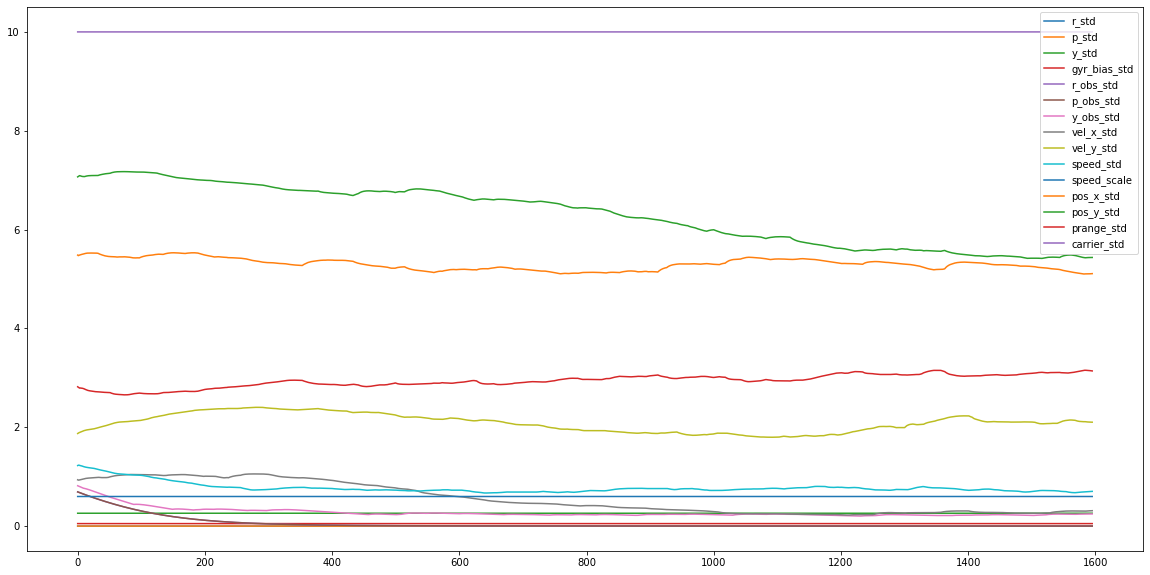

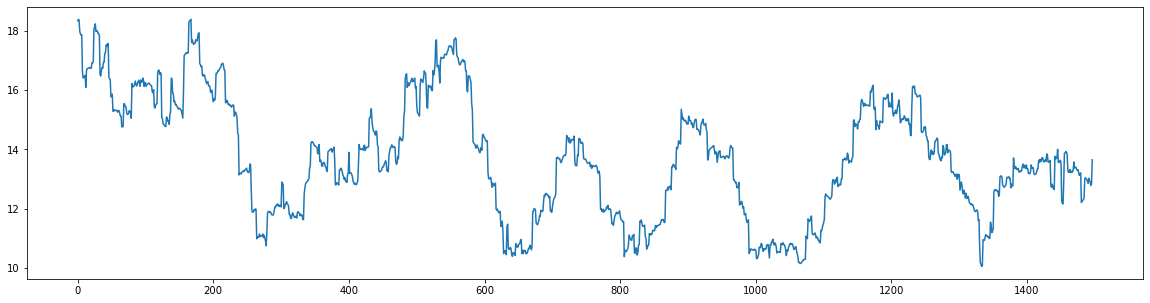

In [343]:
# Create large figure
fig = plt.figure(figsize=(20, 10))
# Plot all parameters
for i in range(len((r_std, p_std, y_std, gyr_bias_std, r_obs_std, p_obs_std, y_obs_std, vel_x_std, vel_y_std, speed_std, speed_scale, pos_x_std, pos_y_std, prange_std, carrier_std))):
    plt.plot([par[i] for par in opt_state_dict_list])
plt.legend(('r_std', 'p_std', 'y_std', 'gyr_bias_std', 'r_obs_std', 'p_obs_std', 'y_obs_std', 'vel_x_std', 'vel_y_std', 'speed_std', 'speed_scale', 'pos_x_std', 'pos_y_std', 'prange_std', 'carrier_std'))

fig = plt.figure(figsize=(20, 5))
# Plot running average of loss
plt.plot(np.convolve([par[-1] for par in opt_state_dict_list], np.ones((100,))/100, mode='valid'))

In [342]:
# k-step transition predict step gradient descent
K_window = 5
shuffled_times = list(range(T_start + IMU_rate_div, T - IMU_rate_div, IMU_rate_div))
np.random.shuffle(shuffled_times)
for t_0 in tqdm(range(len(shuffled_times))):
    t_0_shuffled = shuffled_times[t_0]
    recorded_data = reset_filter(test_filter, t_0_shuffled-IMU_rate_div)

    dyn_parameters = recorded_data['dynamics_parameters'][-1]
    obs_parameters = recorded_data['observation_parameters'][-1]
    prev_timestamp = timestamp[t_0_shuffled-IMU_rate_div]
    dd_idx = recorded_data['last_update_gnss']
    gt_idx = recorded_data['last_update_gt']
    
    loss = 0.0
    
    for k in range(K_window):
        t = t_0_shuffled + k*IMU_rate_div
        # Load IMU data
        timestamp_t, or_quat_t, or_cov_t, ang_vel_t, ang_vel_cov_t, lin_acc_t, lin_acc_cov_t = timestamp[t], or_quat[t], or_cov[t], ang_vel[t], ang_vel_cov[t], lin_acc[t], lin_acc_cov[t]

        # Compute time difference
        dt = (timestamp_t - prev_timestamp)
        prev_timestamp = timestamp_t

        test_filter.update_dynamics(
            dt=dt, 
            pos_x_std=pos_x_std, 
            pos_y_std=pos_y_std, 
            pos_z_std=torch.tensor(dyn_parameters['pos_z_std']), 
            vel_x_std=vel_x_std, 
            vel_y_std=vel_y_std, 
            vel_z_std=torch.tensor(dyn_parameters['vel_z_std']), 
            r_std=r_std, 
            p_std=p_std, 
            y_std=y_std, 
            acc_bias_std=torch.tensor(dyn_parameters['acc_bias_std']), 
            gyr_bias_std=gyr_bias_std
        )

        estimated_state = imu_predict_and_update(test_filter, lin_acc_t, ang_vel_t, or_quat_t, r_obs_std, p_obs_std, y_obs_std, torch.tensor(obs_parameters['imu_robust_threshold']), m_estimation=False)
    
        loss += imu_measurement_loss(or_quat_t, estimated_state)*0.05
    
        # VO data
        vo_idx = recorded_data['last_update_vo']
        new_vo_idx = imu_to_vo_idx(t)
        if new_vo_idx > vo_idx:
            vo_idx = new_vo_idx

            # Load VO data
            landmark_3d, pixel_2d, K, ransac_R, ransac_t = load_vo_data(vo_idx, vo_data, size=50)
            
            estimated_state = vo_update(test_filter, estimated_state, landmark_3d, pixel_2d, K, ransac_R, ransac_t, speed_std, speed_scale, torch.tensor(obs_parameters['speed_robust_threshold']), vel_scaling_factor=IMU_rate_div/27/dt, m_estimation=False)

            loss += vo_measurement_loss(ransac_t, estimated_state)*0.1
        
        new_dd_idx = imu_to_gnss_idx(t)
        if new_dd_idx > dd_idx:
    #         print("GNSS update: ", t)
            dd_idx = new_dd_idx

            # Load GNSS observables
            rover_code, base_code, rover_carr, base_carr, rover_cnos, satpos, idx_code_mask, idx_carr_mask = to_tensor(read_gnss_data(dd_data, dd_idx, 'mixed'))

            gnss_observation, idx_code_mask, idx_carr_mask, ref = calc_gnss_observation(rover_code, base_code, rover_carr, base_carr, satpos, idx_code_mask, idx_carr_mask, ref=None, include_carrier=False)

            estimated_state = gnss_update(test_filter, estimated_state, gnss_observation, satpos, ref, inter_const_bias, idx_code_mask, idx_carr_mask, prange_std, carrier_std, torch.tensor(obs_parameters['prange_robust_threshold']), m_estimation=True)
              
            loss += gnss_measurement_loss(gnss_observation, estimated_state)*0.2
    
    # Supervised update
    new_gt_idx = imu_to_gt_idx(t)
    if new_gt_idx > gt_idx:
        gt_idx = new_gt_idx
        loss += supervised_position_loss(gt_pos[gt_idx], estimated_state)
        
    if type(loss) != float: # and t_0%10==0:    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        opt_state_dict_list.append([
            r_std.detach().numpy().copy(), p_std.detach().numpy().copy(), y_std.detach().numpy().copy(), gyr_bias_std.detach().numpy().copy(), r_obs_std.detach().numpy().copy(), p_obs_std.detach().numpy().copy(), y_obs_std.detach().numpy().copy(), vel_x_std.detach().numpy().copy(), vel_y_std.detach().numpy().copy(), speed_std.detach().numpy().copy(), speed_scale.detach().numpy().copy(), pos_x_std.detach().numpy().copy(), pos_y_std.detach().numpy().copy(), prange_std.detach().numpy().copy(), carrier_std.detach().numpy().copy(), loss.detach().numpy().copy()
            ])
        r_obs_std = get_std(r_obs_std_raw)
        p_obs_std = get_std(p_obs_std_raw)
        y_obs_std = get_std(y_obs_std_raw)

        vel_x_std = get_std(vel_x_std_raw)
        vel_y_std = get_std(vel_y_std_raw)
        speed_std = get_std(speed_std_raw)
        # speed_scale = get_std(speed_scale_raw)

        pos_x_std = get_std(pos_x_std_raw)
        pos_y_std = get_std(pos_y_std_raw)

        prange_std = get_std(prange_std_raw)
        carrier_std = get_std(carrier_std_raw)

        print("Loss ", loss)
#         print("Measurement grad ", prange_std.grad, carrier_std.grad)
#         print("Dynamics grads ", pos_x_std.grad, pos_y_std.grad)

  0%|          | 0/1596 [00:00<?, ?it/s]

Loss  tensor(14.0105, grad_fn=<AddBackward0>)
Loss  tensor(12.5060, grad_fn=<AddBackward0>)
Loss  tensor(42.7441, grad_fn=<AddBackward0>)
Loss  tensor(21.6009, grad_fn=<AddBackward0>)
Loss  tensor(9.9876, grad_fn=<AddBackward0>)
Loss  tensor(7.4615, grad_fn=<AddBackward0>)
Loss  tensor(132.7464, grad_fn=<AddBackward0>)
Loss  tensor(31.2398, grad_fn=<AddBackward0>)
Loss  tensor(8.5442, grad_fn=<AddBackward0>)
Loss  tensor(23.0013, grad_fn=<AddBackward0>)
Loss  tensor(8.0440, grad_fn=<AddBackward0>)
Loss  tensor(48.1659, grad_fn=<AddBackward0>)
Loss  tensor(7.9334, grad_fn=<AddBackward0>)
Loss  tensor(7.0405, grad_fn=<AddBackward0>)
Loss  tensor(7.0320, grad_fn=<AddBackward0>)
Loss  tensor(11.9559, grad_fn=<AddBackward0>)
Loss  tensor(8.6968, grad_fn=<AddBackward0>)
Loss  tensor(14.2245, grad_fn=<AddBackward0>)
Loss  tensor(8.4766, grad_fn=<AddBackward0>)
Loss  tensor(7.4570, grad_fn=<AddBackward0>)
Loss  tensor(7.2766, grad_fn=<AddBackward0>)
Loss  tensor(8.9911, grad_fn=<AddBackward0>)

## Evaluate and Visualize

In [84]:
estimated_states = torch.zeros(T, state_dim)
for i, t in tqdm(enumerate(range(T_start+IMU_rate_div, T, IMU_rate_div))):
    estimated_states[t, :] = recorded_data['estimated_states'][i][0, :]

0it [00:00, ?it/s]

In [ ]:
timestep = 5

print(tmp_outs[timestep][2])

get_error = lambda x, timestep: torch.norm(x[0, :, :3] - sync_gt[timestep], dim=-1) 

# Initial -> Predict
plt.hist(get_error(tmp_outs[timestep][0]['initial states'], timestep).numpy(), color='r', alpha=0.5, label='initial errors')
plt.hist(get_error(tmp_outs[timestep][0]['predicted state'], timestep).numpy(), color='g', alpha=0.5, label='predict errors')
plt.legend()
plt.show()

plt.bar(get_error(tmp_outs[timestep][0]['initial states'], timestep).numpy(), torch.exp(tmp_outs[timestep][0]['initial logwt'][0, :]).numpy(), width=0.3, color='r', alpha=0.3, label='initial weights')
plt.bar(get_error(tmp_outs[timestep][0]['predicted state'], timestep).numpy(), torch.exp(tmp_outs[timestep][0]['predicted logwt'][0, :]).numpy(), width=0.3, color='g', alpha=0.3, label='predicted weights')
plt.legend()
plt.show()

# Predict -> Update
if tmp_outs[timestep][1] is not None:
    plt.hist(get_error(tmp_outs[timestep][1]['initial states'], timestep).numpy(), color='g', alpha=0.5, label='predict errors')
    plt.hist(get_error(tmp_outs[timestep][1]['corrected state'], timestep).numpy(), color='b', alpha=0.5, label='correct errors')
    plt.legend()
    plt.show()
    
    plt.bar(get_error(tmp_outs[timestep][1]['initial states'], timestep).numpy(), torch.exp(tmp_outs[timestep][1]['initial logwt'][0, :]).numpy(), width=0.3, color='g', alpha=0.3, label='predicted weights')
    plt.bar(get_error(tmp_outs[timestep][1]['corrected state'], timestep).numpy(), torch.exp(tmp_outs[timestep][1]['corrected logwt'][0, :]).numpy(), width=0.3, color='b', alpha=0.3, label='corrected weights')
    plt.legend()
    plt.show()

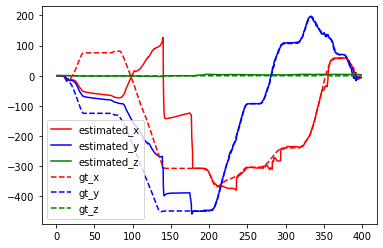

In [85]:
tmax = t-1

state_range = range(T_start, tmax, IMU_rate_div)
num_elem = len(state_range)

lower_gt = imu_to_gt_idx(T_start)
upper_gt = imu_to_gt_idx(tmax)

gt_len = upper_gt-lower_gt

states = estimated_states.detach()
plt.plot(np.linspace(1, gt_len, num=num_elem), states[state_range, 0], "r", label="estimated_x")
plt.plot(np.linspace(1, gt_len, num=num_elem), states[state_range, 1], "b", label="estimated_y")
plt.plot(np.linspace(1, gt_len, num=num_elem), states[state_range, 2], "g", label="estimated_z")

plt.plot(np.linspace(1, gt_len, num=gt_len), gt_pos[lower_gt:upper_gt, 0], "r--", label="gt_x")
plt.plot(np.linspace(1, gt_len, num=gt_len), gt_pos[lower_gt:upper_gt, 1], "b--", label="gt_y")
plt.plot(np.linspace(1, gt_len, num=gt_len), gt_pos[lower_gt:upper_gt, 2], "g--", label="gt_z")

# plt.plot(gt_pos[lower_t_s-root_t_s:, 0], "r--", label="gt_x")
# plt.plot(gt_pos[lower_t_s-root_t_s:, 1], "b--", label="gt_y")
# plt.plot(gt_pos[lower_t_s-root_t_s:, 2], "g--", label="gt_z")

plt.legend()

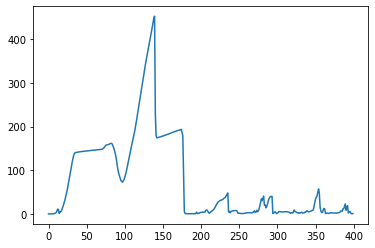

In [86]:
state_range = range(T_start, tmax, 400)
gt_range = [imu_to_gt_idx(t) for t in state_range]

tracking_error = torch.norm(states[state_range, :2] - gt_pos[gt_range, :2], dim=1)
plt.plot(tracking_error)
# plt.ylim((0, 2))

In [31]:
torch.mean(tracking_error)

tensor(40.9640, dtype=torch.float64)

In [ ]:
test_filter.particle_log_weights

In [ ]:
test_filter.particle_states[0, :, :3], torch.sum(
                torch.exp(test_filter.particle_log_weights[:, :, np.newaxis])
                * test_filter.particle_states,
                dim=1,
            )[0, :3]

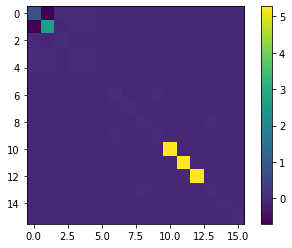

In [78]:
plt.imshow(test_filter._belief_covariance[0, :, :])
# plt.imshow(test_filter._belief_covariance[0, :, :])
plt.colorbar()
# torch.linalg.cond(test_filter.ekf._belief_covariance[0, :3, :3])


In [87]:
state_or_eul = np.stack(list(quaternion_to_euler_angle_vectorized(states[state_range, 6], states[state_range, 7], states[state_range, 8], states[state_range, 9])), 1)

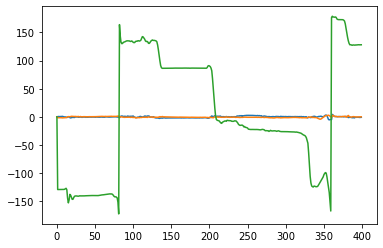

In [88]:
viz_block = range(0, len(state_or_eul))
plt.plot(state_or_eul[viz_block, 0])
plt.plot(state_or_eul[viz_block, 1])
plt.plot(state_or_eul[viz_block, 2])

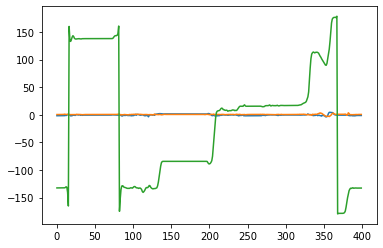

In [89]:
plt.plot(gt_rot[gt_range, 0])
plt.plot(gt_rot[gt_range, 1])
plt.plot(gt_rot[gt_range, 2])

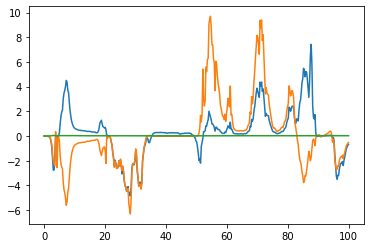

In [35]:
state_vel = states[state_range, 3:6].numpy()

viz_block_kHz = range(0, len(state_vel))
plt.plot(np.linspace(0, 100, num=len(viz_block_kHz)), state_vel[viz_block_kHz, 0])
plt.plot(np.linspace(0, 100, num=len(viz_block_kHz)), state_vel[viz_block_kHz, 1])
plt.plot(np.linspace(0, 100, num=len(viz_block_kHz)), state_vel[viz_block_kHz, 2])

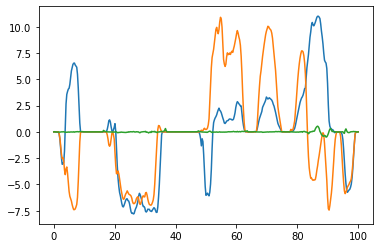

In [36]:
plt.plot(np.linspace(0, 100, num=len(gt_range)-1), np.ediff1d(gt_pos[gt_range, 0]))
plt.plot(np.linspace(0, 100, num=len(gt_range)-1), np.ediff1d(gt_pos[gt_range, 1]))
plt.plot(np.linspace(0, 100, num=len(gt_range)-1), np.ediff1d(gt_pos[gt_range, 2]))

  0%|          | 0/6 [00:00<?, ?it/s]

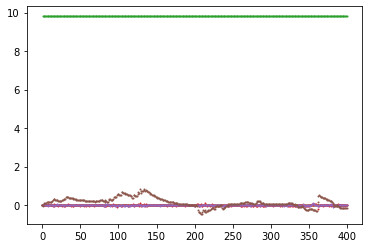

In [227]:
for i in tqdm(range(10, 10+6)):
    plt.scatter(range(len(state_range)), states[state_range, i].numpy(), s=1)

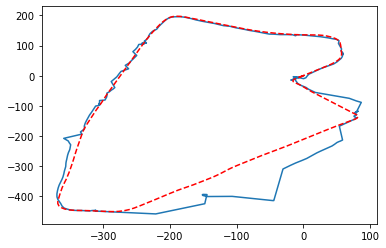

In [37]:
plt.plot(states[state_range, 0], states[state_range, 1])
plt.plot(gt_pos[gt_range, 0], gt_pos[gt_range, 1], "r--")

In [ ]:
# VO stuff

# VO data
    vo_idx = recorded_data['last_update_vo']
    new_vo_idx = imu_to_vo_idx(t)
    if new_vo_idx > vo_idx:
    # if True:
        vo_idx = new_vo_idx

        # Load VO data
        landmark_3d, pixel_2d, K, ransac_R, ransac_t = load_vo_data(vo_idx, vo_data, size=50)
    #     # Load quaternion corresponding to previous image frame
    #     prev_frame_quat = or_quat[vo_to_imu_idx(vo_idx-1)].detach().clone()
    #     prev_frame_quat[[1, 2]] = prev_frame_quat[[2, 1]]
        # Compute change in orientation since previous frame
    #         delta_quat = tf.matrix_to_quaternion(torch.tensor(cv2.Rodrigues(ransac_R)[0]))
        delta_quat = tf.matrix_to_quaternion(torch.tensor(cv2.Rodrigues(np.zeros(3))[0]))
        # Update VO base model
        vel_meas = torch.tensor([0.0, np.linalg.norm(ransac_t), 0.0]).float().reshape(1, -1)

        if vel_meas[0, 1] < 0.05:
            vel_meas = torch.zeros(1, 3).float()
            vel_std = 1e-5
        else:
            vel_std = 2.0

        test_filter.update_vo_base(std=vel_std)
        estimated_state = test_filter(controls=None, observations=vel_meas)

#         # Update VO landmark model
#         test_filter.update_vo(landmarks=landmark_3d, delta_quat=delta_quat, intrinsic=K)
#         # Run filter
#         print("VO: ", vo_idx)
#         estimated_state = test_filter(controls=None, observations=pixel_2d.reshape(1, -1))
        print("Est_pos: ", estimated_state[:, :3])
        print("Est_vel: ", estimated_state[:, 3:6])
        print("Est_quat: ", estimated_state[:, 6:10])
        print("Est_bias: ", estimated_state[:, 10:13])

In [ ]:
# m_model_params = list(pf_measurement_model.parameters())
# d_model_params = list(dynamics_model.parameters())
# m_model_params, d_model_params

In [ ]:
# tmp_a = torch.ones(1, 10)

# for _ in range(10):
#     tmp_a, Q = dynamics_model(tmp_a, torch.ones(1, 6))
# tmp_obj = nll_objective(torch.tensor([1.0, 1.0, 1.0]).reshape(1, -1), tmp_a[:, :3], torch.diagonal(Q, dim1=-2, dim2=-1)[:, :3])
# print(tmp_obj)
# torch.autograd.grad(outputs=tmp_obj, inputs=d_model_params, allow_unused=True, retain_graph=True)

In [ ]:
# optimizer = torch.optim.SGD(test_filter.parameters(), lr=0.01, momentum=0.9)
# optimizer.zero_grad()
# loss_fn = torch.nn.MSELoss()
# nll_objective = torch.nn.GaussianNLLLoss()

In [ ]:
test_filter.measurement_model.mode

In [ ]:
# gt_rot_to_imu_quat(gt_rot[imu_to_gt_idx(t)]), estimated_state[0, 6:10].detach().numpy(), imu_observation
# plt.plot([gt_pos_delta(i) for i in range(5000)])
tmp_state = estimated_state.detach()
tmp_state[:, 3:6] = torch.tensor(gt_pos_delta(vo_idx))
plt.hist((test_filter.measurement_model(tmp_state)[0] - pixel_2d.reshape(1, -1)).numpy().flatten())

In [ ]:
plt.plot([gt_pos_delta(imu_to_vo_idx(t)) for t in range(T_start, T, 10)])

In [ ]:
gt_pos_delta(vo_idx)

In [ ]:
tmp_gt_delta = gt_pos_delta(vo_idx)
tf.quaternion_apply(tf.quaternion_invert(gt_rot_to_imu_quat(gt_rot[imu_to_gt_idx(vo_to_imu_idx(vo_idx)), :])), torch.tensor([tmp_gt_delta[0], tmp_gt_delta[1], tmp_gt_delta[2]]))

In [ ]:
rmat, _ = cv2.Rodrigues(ransac_R)
rmat = torch.from_numpy(rmat).float()
print(rmat)
rmat = tf.quaternion_to_matrix(delta_quat).float()
print(rmat)

In [ ]:
tf.quaternion_apply(tmp_quat, torch.tensor(tmp_gt_delta)), torch.tensor(ransac_t.flatten())

In [ ]:
# imu_to_gt_idx(vo_to_imu_idx(vo_idx))
tmp_quat = eul2quat(torch.tensor(gt_rot[imu_to_gt_idx(vo_to_imu_idx(vo_idx)), :]))
tmp_gt_delta = gt_pos_delta(vo_idx)*0.5
tmp_body_vel = tf.quaternion_apply(tmp_quat, torch.tensor(tmp_gt_delta))
tmp_body_vel[[0, 2, 1]]

In [ ]:
tmp_ls = []
quat_body_to_cam = torch.tensor([ 0.05217445, -0.51712999,  0.0117416 , -0.74978414])
for traj_idx in tqdm(range(787)):
    vo_idx = imu_to_vo_idx(gt_to_imu_idx(traj_idx))

    tmp_gt_delta = gt_pos_delta(vo_idx)
    if np.linalg.norm(tmp_gt_delta)>0.7:
        landmark_3d, pixel_2d, K, ransac_R, ransac_t = load_vo_data(vo_idx, vo_data)
        tmp_quat = eul2quat(torch.tensor(gt_rot[imu_to_gt_idx(vo_to_imu_idx(vo_idx)), :]))
        body_vel_gt = tf.quaternion_apply(tmp_quat, torch.tensor(tmp_gt_delta)).numpy()
#         body_vel_gt[1] = -body_vel_gt[1]
        
        est_quat = quat_between(body_vel_gt, ransac_t.flatten())
#         tmp_ls.append(est_quat)
        print(traj_idx, body_vel_gt, ransac_t.flatten())

In [ ]:
# np.mean(tmp_ls, axis=0)
tmp_ls

In [ ]:
traj_idx = 0
plt.plot([gt_pos_delta(imu_to_vo_idx(gt_to_imu_idx(t)))[0] for t in range(traj_idx, traj_idx + 200)], label='East')
plt.plot([gt_pos_delta(imu_to_vo_idx(gt_to_imu_idx(t)))[1] for t in range(traj_idx, traj_idx + 200)], label='North')
plt.legend()

In [ ]:
traj_idx = 0
plt.plot([lin_acc[gt_to_imu_idx(t)][0]**2 + lin_acc[gt_to_imu_idx(t)][1]**2 + (lin_acc[gt_to_imu_idx(t)][2] - 9.81)**2 for t in range(traj_idx, traj_idx + 200)])

In [ ]:
def scale_line_search(vel):
    # Project 3D points to image plane
    img_pts, _ = cv2.projectPoints(landmark_3d.numpy(), np.zeros((3, 1)), vel.reshape(3, 1), K.numpy(), np.zeros((4, 1)))
    img_pts = img_pts.reshape(-1, 2)
    # Calculate reprojection error
    error = np.linalg.norm(pixel_2d.numpy() - img_pts, axis=1)
    # plt.hist(error.flatten(), alpha=0.5)
    return error.mean() + error.std() 

scales = np.arange(0.0, 0.2, 0.01)
plt.plot([scale for scale in scales], [scale_line_search(np.array([-scale, 0.0, -0.215])) for scale in scales])

In [ ]:
# UNITTEST: Experiments for debugging visual odometry landmarks

vo_idx = imu_to_vo_idx(gt_to_imu_idx(traj_idx + 148))

landmark_3d, pixel_2d, K, ransac_R, ransac_t = load_vo_data(vo_idx, vo_data, size=200, error_level=100.0)

def scale_line_search(scale):
    tmp_gt_delta = gt_pos_delta(vo_idx)
    tmp_quat = eul2quat(torch.tensor(gt_rot[imu_to_gt_idx(vo_to_imu_idx(vo_idx)), :]))
#     tmp_state = estimated_state.detach().clone()
    tmp_state = torch.zeros(1, 16)
    tmp_state[:, 6:10] = tmp_quat
    
    delta_quat = tf.matrix_to_quaternion(torch.tensor(cv2.Rodrigues(ransac_R)[0]))
#     prev_frame_quat = or_quat[vo_to_imu_idx(vo_idx-1)].detach().clone()
#     prev_frame_quat[[1, 2]] = prev_frame_quat[[2, 1]]
#     cur_frame_quat = or_quat[vo_to_imu_idx(vo_idx)].detach().clone()
#     cur_frame_quat[[1, 2]] = cur_frame_quat[[2, 1]]
#     delta_quat = quat_delta(prev_frame_quat, cur_frame_quat)
    
    tmp_t = torch.tensor(ransac_t.flatten())
    tmp_t[1] = -tmp_t[1]
    tmp_t  = tmp_t[[1, 0, 2]]
    
    tmp_state[:, 3:6] = 2.0*tf.quaternion_apply(tf.quaternion_invert(tmp_quat), tmp_t)
    fname_ransac = f'tmp_res_ransac_{vo_idx}'
    
    test_filter.update_vo(landmarks=landmark_3d, delta_quat=delta_quat, intrinsic=K)
    expected_observation, R = test_filter.measurement_model(tmp_state)
    abs_res_ransac = (expected_observation - pixel_2d.reshape(1, -1)).numpy()
    
    tmp_state[:, 3:6] = torch.tensor(tmp_gt_delta)/scale
    fname_gt = f'tmp_res_gt_{vo_idx}'
    
    test_filter.update_vo(landmarks=landmark_3d, delta_quat=delta_quat, intrinsic=K)
    expected_observation, R = test_filter.measurement_model(tmp_state)
    abs_res_gt = (expected_observation - pixel_2d.reshape(1, -1)).numpy()
    
#     abs_res[abs_res > 5] = 0.0
    plt.hist(abs_res_ransac.flatten(), alpha=0.5, label='ransac')
    plt.hist(abs_res_gt.flatten(), alpha=0.5, label='gt')
    plt.legend()
    
#     np.save(fname_ransac, abs_res_ransac.flatten())
#     np.save(fname_gt, abs_res_gt.flatten())
    
    
    val = np.square(abs_res_gt).sum() - np.square(abs_res_ransac).sum()
    return val

# plt.plot([scale_line_search(0.5 + i/10) for i in tqdm(range(100))])
scale_line_search(1.0)

In [ ]:
# estimated_state, tf.quaternion_invert(imu_observation)
new_vo_idx

In [ ]:
# For RBPF

def run_timestep(t, context):
    prev_timestamp, dd_idx, vo_idx, recorded_data = context
    
    # Load IMU data
    timestamp_t, or_quat_t, or_cov_t, ang_vel_t, ang_vel_cov_t, lin_acc_t, lin_acc_cov_t = timestamp[t], or_quat[t], or_cov[t], ang_vel[t], ang_vel_cov[t], lin_acc[t], lin_acc_cov[t]

    # Compute time difference 
    dt = (timestamp_t - prev_timestamp)
    prev_timestamp = timestamp_t
    test_filter.update_dt_cov(dt, xy_std, z_std, q_std, v_std)

    # Orientation (world -> body) to (body -> world)
#     or_quat_t[3] *= -1     # fix for ENU consistency

    # Predict step
    controls = torch.cat((lin_acc_t, ang_vel_t)).float()
    imu_observation = or_quat_t.float()
    imu_observation[[1, 2]] = imu_observation[[2, 1]]
    test_filter.update_imu_std(or_cov_t.float())
    estimated_state = test_filter(controls=controls[None, :], observations=imu_observation[None, :])
#     print("Heading: ", estimated_state[:, 3:7], tf.quaternion_invert(imu_observation))
    
    tmp_outs_1 = test_filter.tmp_outs
    tmp_outs_2 = test_filter.tmp_outs
    tmp_outs_2['corrected state'] = tmp_outs_2['predicted state']
    tmp_outs_2['corrected logwt'] = tmp_outs_2['predicted logwt']
    tmp_outs_2['corrected cov'] = tmp_outs_2['predicted cov']
    
    # Null corrected state and observation data
    corrected_state = None
    gnss_observation = None
    gnss_observation_context = None
    
    new_vo_idx = imu_to_vo_idx(t)
    if new_vo_idx > vo_idx:
#         print("VO update: ", t)
        vo_idx = new_vo_idx
        
        # VO does better at predicting low velocities
        vo_val = np.linalg.norm(vo_data['vo'][vo_idx, :])/1.5              # VO velocity
#         vo_val = gt_vel[imu_to_gt_idx(t), 1]           # Ground truth velocity
        vo_observation = torch.zeros(1, 3)
        vo_observation[0, 1] = vo_val
#         if vo_val<3:
#             test_filter.update_vo_std(1e-4)
#         else:
        test_filter.update_vo_std(1e-3)
            
        
        
        estimated_state = test_filter(controls=None, observations=vo_observation)
        expected_observation, R = test_filter.measurement_model.kalman_filter_measurement_model(estimated_state)
#         print("Vel: ", estimated_state[0, 7:10], expected_observation, vo_observation)
        

    new_dd_idx = imu_to_gnss_idx(t)
    if new_dd_idx > dd_idx:
#         print("GNSS update: ", t)
        dd_idx = new_dd_idx

        # Load GNSS observables
        rover_code, base_code, rover_carr, base_carr, rover_cnos, satpos, idx_code_mask, idx_carr_mask = to_tensor(read_gnss_data(dd_data, dd_idx, 'mixed'))

        # Load Integer hypotheses
        ref, N_hypo_dict = None, None
#         ref, N_hypo_dict = get_N_hypotheses(timestamp_t, ints_data)

        gnss_observation, idx_code_mask, idx_carr_mask, ref = calc_gnss_observation(rover_code, base_code, rover_carr, base_carr, satpos, idx_code_mask, idx_carr_mask, ref=ref)
        
        if gnss_observation is not None:
            
            # Cycle slip detection
            cs_data = mixed_data[dd_idx, :]
        
            # Dynamic covariances
            cov_observation = calc_gnss_cov(rover_cnos, satpos, estimated_state[0, :3])
            
            cov_ambiguity = calc_ambiguity_cov(cs_data, idx_carr_mask)
            
            test_filter.update_ambiguity_cov(cov_ambiguity)
#             visible_sats = sum(idx_code_mask)
#             prange_std = 20.0/visible_sats
#             carrier_std = 20.0/visible_sats if visible_sats<3 else 1.0/visible_sats
            
            # Update satellite and other context data in the measurement model
            test_filter.update_sats(satpos, idx_code_mask, idx_carr_mask, ref, inter_const_bias=inter_const_bias, N_hypo_dict=N_hypo_dict, pf_std=(cov_observation*jitter_measurement, cov_observation*jitter_measurement, cov_observation*0.1*jitter_measurement), kf_std=(cov_observation, cov_observation, cov_observation*0.1))
            gnss_observation_context = (satpos, idx_code_mask, idx_carr_mask, ref, inter_const_bias)

            # Debug
            tmp_state = torch.zeros(1, 10)
            tmp_state[0, :3] = torch.tensor(gt_pos[imu_to_gt_idx(t), :])
    #             expected_observation, R = test_filter.measurement_model.kalman_filter_measurement_model(tmp_state)

    #             if N_hypo_dict is not None:
    #                 print(expected_observation, gnss_observation)

            # Update step
            corrected_state = test_filter(observations=gnss_observation[None, :], controls=None)
            
            print("Current err: ", torch.norm(corrected_state[0, :3] - tmp_state[0, :3]))

            tmp_outs_2 = test_filter.tmp_outs
            
    # Ensure no NaN's so far
    assert not (torch.any(torch.isnan(estimated_states[t-T_start, :])))
    
#     recorded_data['controls'].append(controls)
#     recorded_data['imu_observation'].append(imu_observation)
#     recorded_data['gnss_observation'].append(gnss_observation)
#     recorded_data['gnss_observation_context'].append(gnss_observation_context)
    
    return estimated_state, corrected_state, (prev_timestamp, dd_idx, vo_idx, recorded_data), (tmp_outs_1, tmp_outs_2, prev_timestamp)

Debugging---

In [ ]:
tmp_outs = []
sync_gt = []

prev_gt_idx = -1

with torch.no_grad():
    for t in tqdm(range(T_start, T, IMU_rate_div)):
        estimated_state, corrected_state, context, _tmp_outs = run_timestep(t, context)
        if imu_to_gt_idx(t) != prev_gt_idx:
            prev_gt_idx = imu_to_gt_idx(t)
            tmp_outs.append(_tmp_outs)
            sync_gt.append(torch.tensor(gt_pos[prev_gt_idx, :]))
        
        if corrected_state is None:
            estimated_states[t, :] = estimated_state
        else:
            estimated_states[t, :] = corrected_state
#             print("GT idx: ", prev_gt_idx)
#             # Update filter parameters
#             with torch.enable_grad():
                
#                 dynamics_objective = nll_objective(corrected_state.detach(), , torch.diagonal(Q, dim1=-2, dim2=-1)[:, :3])

In [ ]:
save_data['weights'].shape

In [ ]:
save_data = {
    'states': np.array([tmp_outs[timestep][1]['corrected state'][0].numpy() for timestep in tqdm(range(len(tmp_outs)))]),
    'weights': np.array([torch.exp(tmp_outs[timestep][1]['corrected logwt'][0]).numpy() for timestep in tqdm(range(len(tmp_outs)))]),
    'cov': np.array([tmp_outs[timestep][1]['corrected cov'].numpy() for timestep in tqdm(range(len(tmp_outs)))]),
    'UTCtime': np.array([tmp_outs[timestep][2] for timestep in tqdm(range(len(tmp_outs)))]),
    'gt': np.array([sync_gt[timestep].numpy() for timestep in tqdm(range(len(tmp_outs)))]),
}
np.save(os.path.abspath('/oak/stanford/groups/gracegao/HKdataset/data_06_22_22/Filter_data/rbpf_det_20p_9_4_1210_loop1.npy'), save_data)
# np.save(os.path.abspath('/oak/stanford/groups/gracegao/HKdataset/data_06_22_22/Filter_data/ekf_9_4_1130_loop1.npy'), save_data)

In [ ]:
# # with open(, 'wb') as f:
    
# save_data = {
#     'states': np.array([tmp_outs[timestep][0]['predicted state'][0].numpy() for timestep in tqdm(range(len(tmp_outs)))]),
#     'weights': np.array([torch.exp(tmp_outs[timestep][0]['predicted logwt'][0]).numpy() for timestep in tqdm(range(len(tmp_outs)))]),
#     'cov': np.array([tmp_outs[timestep][0]['predicted cov'][0].numpy() for timestep in tqdm(range(len(tmp_outs)))]),
#     'UTCtime': np.array([tmp_outs[timestep][2] for timestep in tqdm(range(len(tmp_outs)))]),
#     'gt': np.array([sync_gt[timestep].numpy() for timestep in tqdm(range(len(tmp_outs)))]),
# }
# np.save(os.path.abspath('/oak/stanford/groups/gracegao/HKdataset/data_06_22_22/Filter_data/full_8_26_1830_1.npy'), save_data)

In [ ]:
save_data = np.load(os.path.abspath('/oak/stanford/groups/gracegao/HKdataset/data_06_22_22/Filter_data/full_8_17_1515_1.npy'), allow_pickle=True).item()

In [ ]:
def compute_tau_bisection(epsilon, diff_xh_xi, weights, init_tau=30.0):
    tau = init_tau
    
    for _ in range(20): 
        is_inside = diff_xh_xi < tau
        filter_integral = torch.sum(weights[is_inside])
        if filter_integral < 1 - epsilon:
            tau = 3/2 * tau
        else:
            tau = 1/2 * tau
            
    return tau

def compute_tau_empirical_sigma(epsilon, diff_xh_xi, weights):
    sigma = torch.sqrt(torch.sum(weights * torch.square(diff_xh_xi))) + 1e-6
    return torch.distributions.normal.Normal(loc=0.0, scale=sigma).icdf(torch.tensor(1-epsilon))

def compute_tau_sigma(epsilon, var, weights):
    sigma = torch.sqrt(torch.sum(weights * var)) + 1e-6
    return torch.distributions.normal.Normal(loc=0.0, scale=sigma).icdf(torch.tensor(1-epsilon))

def integrate_beliefs_1d(estimated_state, all_hypo_log_weights, all_hypo_states, all_hypo_cov, epsilon=0.01, dim=0):
    if len(all_hypo_states.shape)==2:
        all_hypo_states = all_hypo_states[None, :, :]
        all_hypo_log_weights = all_hypo_log_weights[None, :]
        all_hypo_cov = all_hypo_cov[None, :, :, :]
    
    num_hypo = all_hypo_log_weights.shape[0]
    
#     diff_xh_xi = torch.abs(estimated_state[dim] - all_hypo_states[:, :, dim])
    all_hypo_tau = torch.tensor([compute_tau_sigma(epsilon, all_hypo_cov[0, i, dim, dim], 1.0) for i in range(all_hypo_states.shape[1])])
    diff_xh_xi = torch.abs(estimated_state[dim] - all_hypo_states[:, :, dim]) + all_hypo_tau[None, :]
    print(all_hypo_tau, torch.sqrt(all_hypo_cov[:, :, dim, dim]))
#     diff_xh_xi = torch.abs(estimated_state[dim] - all_hypo_states[:, :, dim]) + torch.sqrt(all_hypo_cov[:, :, dim, dim])
    
    weights = torch.exp(all_hypo_log_weights)
    
#     diff_atau_xi = torch.abs(estimated_state[dim] + tau - all_hypo_states[:, :, dim])
#     diff_btau_xi = torch.abs(estimated_state[dim] - tau - all_hypo_states[:, :, dim])
    
#     diff_ptau_xi = torch.maximum(diff_atau_xi, diff_btau_xi)
#     diff_mtau_xi = torch.minimum(diff_atau_xi, diff_btau_xi)
    
    tau = compute_tau_empirical_sigma(epsilon, diff_xh_xi, weights)
#     tau = compute_tau_sigma(epsilon, all_hypo_cov[:, :, dim, dim], weights)

    #     sigma = 5.0 # all_hypo_cov[:, :, dim, dim]
    #     integral_xh_xi = torch.erf(diff_xh_xi/sigma)
    #     integral_ptau_xi = torch.erf(diff_ptau_xi/sigma)
    #     integral_mtau_xi = torch.erf(diff_mtau_xi/sigma)

    return tau
    

In [ ]:
# plt.bar((torch.tensor(_init_particles[:, 0]) - estimated_state[0]).numpy(), _init_weights, alpha=0.3)

In [ ]:
# for h in tqdm(range(all_hypo_states.shape[0])):
#     plt.bar((all_hypo_states[h, :, 0] - estimated_state[0]).numpy(), torch.exp(all_hypo_log_weights[h, :]).numpy(), width=0.8, alpha=0.2)

In [ ]:
# metric_times = []

# T = len(save_data['UTCtime'])
# gnss_times = dd_data['time_gt'].to_numpy()

# i = 0
# i_N = 1

# for timestep in tqdm(range(i*int(T/i_N), (i+1)*int(T/i_N))):
#     _utctime = save_data['UTCtime'][timestep]
#     dd_tidx = np.argmin(np.abs(gnss_times - _utctime))
#     if np.abs(gnss_times[dd_tidx]-_utctime) > 1/40:
#         continue
    
#     # Load GNSS observables
#     rover_code, base_code, rover_carr, base_carr, satpos, idx_code_mask, idx_carr_mask = to_tensor(read_gnss_data(dd_data, dd_tidx, 'mixed'))

#     gnss_observation, idx_code_mask, idx_carr_mask, ref = calc_gnss_observation(rover_code, base_code, rover_carr, base_carr, satpos, idx_code_mask, idx_carr_mask, ref=None)

#     if gnss_observation is None:
#         continue
    
#     metric_times.append(gnss_times[dd_tidx])
# # print(len(metric_times))
# np.save('/home/users/shubhgup/Codes/KITTI360_Processing/TRI_KF/Filter_data/8_17_1000_times.npy', np.array(metric_times))

In [ ]:
def single_hypo_update(_init_particles, _init_cov, _init_weights, gnss_observation, satpos, idx_code_mask, idx_carr_mask, ref, inter_const_bias, N_hypo_dict=None):
    M, state_dim = _init_particles.shape
    obs_dim = len(gnss_observation)
    
    test_filter.update_sats(satpos, idx_code_mask, idx_carr_mask, ref, inter_const_bias=inter_const_bias, N_hypo_dict=N_hypo_dict)

    # Run EKF correct
    test_filter.ekf._belief_mean = torch.tensor(_init_particles)
    test_filter.ekf._belief_covariance = torch.tensor(_init_cov)

    ekf_correct_particles = test_filter.ekf(controls=None, observations=gnss_observation.expand(M, obs_dim))

    _meas_log_weights = test_filter.measurement_model(
                    states=ekf_correct_particles[None, :, :],
                    observations=gnss_observation[None, :],
                )

    _update_log_weights = torch.log(torch.tensor(_init_weights[None, :])) + _meas_log_weights
    _update_log_weights -= torch.logsumexp(_update_log_weights, dim=1)
    
    return ekf_correct_particles.detach()[:, :3], test_filter.ekf._belief_covariance.detach()[:, :3, :3], _update_log_weights.detach()[0, :]

In [ ]:
def get_uls():
#     gnss_times = dd_data['time_gt'].to_numpy()
#     test_filter.measurement_model.kalman_filter_measurement_model.gnss_model.carrier_N_std = 2.0
#     test_filter.ekf.measurement_model.gnss_model.carrier_N_std = 2.0

    ret_data = {
        'eul': [],
        'nul': [],
        'xh': [],
        'gt': []
    }

    T = len(save_data['UTCtime'])
    
    i = 0
    i_N = 1

    for timestep in tqdm(range(i*int(T/i_N), (i+1)*int(T/i_N))):
        _utctime = save_data['UTCtime'][timestep]
#         dd_tidx = np.argmin(np.abs(gnss_times - _utctime))
#         if np.abs(gnss_times[dd_tidx]-_utctime) > 1/40:
#             continue

#         # Load GNSS observables
#         rover_code, base_code, rover_carr, base_carr, satpos, idx_code_mask, idx_carr_mask = to_tensor(read_gnss_data(dd_data, dd_tidx, 'mixed'))

        _init_particles = None
        _init_weights = None
#         all_hypo_states = torch.tensor(save_data['states'][timestep])[None, None, :]
        all_hypo_states = torch.tensor(save_data['states'][timestep])[None, :, :]
        
        state_dim = all_hypo_states.shape[-1]

#         all_hypo_log_weights = torch.zeros((1, 1, 1))
        all_hypo_log_weights = torch.log(torch.tensor(save_data['weights'][timestep]))[None, :]
        _gt = torch.tensor(save_data['gt'][timestep])

#         M, state_dim = _init_particles.shape

        _init_cov = None
#         all_hypo_cov = torch.tensor(save_data['cov'][timestep])[None, None, :, :] # 1.0*torch.eye(state_dim).expand(M, state_dim, state_dim)
        all_hypo_cov = torch.tensor(save_data['cov'][timestep])[None, :, :, :]
#         ref, N_hypo_dict_all = get_N_hypotheses(_utctime, ints_data)

#         gnss_observation, idx_code_mask, idx_carr_mask, ref = calc_gnss_observation(rover_code, base_code, rover_carr, base_carr, satpos, idx_code_mask, idx_carr_mask, ref=ref)

#         if gnss_observation is None:
#             continue
        
#         if N_hypo_dict_all is None:
#             _hypo_states, _hypo_cov, _hypo_log_weights = single_hypo_update(_init_particles, _init_cov, _init_weights, gnss_observation, satpos, idx_code_mask, idx_carr_mask, ref, inter_const_bias, N_hypo_dict=None)
            
#             all_hypo_states = _hypo_states.unsqueeze(0)
#             all_hypo_cov = _hypo_cov.unsqueeze(0)
#             all_hypo_log_weights = _hypo_log_weights.unsqueeze(0)
#         else:
#             avail_sat_idx = list(N_hypo_dict_all.keys())

#             num_hypo = len(N_hypo_dict_all[avail_sat_idx[0]])

#             all_hypo_states = []
#             all_hypo_cov = []
#             all_hypo_log_weights = []    
        

# #             tmp_state = torch.zeros(1, 10)
# #             tmp_state[0, :3] = torch.tensor(_gt)
# #             test_filter.update_sats(satpos, idx_code_mask, idx_carr_mask, ref, inter_const_bias=inter_const_bias, N_hypo_dict=None)
# #             expected_observation_gt, _ = test_filter.measurement_model.kalman_filter_measurement_model(tmp_state)

#             for hypo_idx in range(num_hypo):
#                 N_hypo_dict = {key: N_hypo_dict_all[key][hypo_idx] for key in avail_sat_idx}

#                 _hypo_states, _hypo_cov, _hypo_log_weights = single_hypo_update(_init_particles, _init_cov, _init_weights, gnss_observation, satpos, idx_code_mask, idx_carr_mask, ref, inter_const_bias, N_hypo_dict=N_hypo_dict)

#                 all_hypo_states.append(_hypo_states)
#                 all_hypo_cov.append(_hypo_cov)
#                 all_hypo_log_weights.append(_hypo_log_weights)

#             all_hypo_states = torch.stack(all_hypo_states)
#             all_hypo_cov = torch.stack(all_hypo_cov)
#             all_hypo_log_weights = torch.stack(all_hypo_log_weights) - np.log(num_hypo)

        estimated_state = torch.sum(
                    torch.exp(all_hypo_log_weights).reshape(-1)[:, None]
                    * all_hypo_states.reshape(-1, state_dim),
                    dim=0,
                )
    
        ret_data['eul'].append(integrate_beliefs_1d(estimated_state, all_hypo_log_weights, all_hypo_states, all_hypo_cov, dim=0))
        ret_data['nul'].append(integrate_beliefs_1d(estimated_state, all_hypo_log_weights, all_hypo_states, all_hypo_cov, dim=1))

        ret_data['xh'].append(estimated_state)
        ret_data['gt'].append(torch.tensor(_gt))

#         if timestep > i*int(T/10) + 0:
#             break
        
#         print(_utctime)
        
    return ret_data, (all_hypo_states, all_hypo_log_weights, estimated_state, torch.tensor(_gt), _init_particles, _init_weights)

ret_data, (all_hypo_states, all_hypo_log_weights, estimated_state, _gt, _init_particles, _init_weights) = get_uls()

In [ ]:
run_x_hat = torch.stack(ret_data['xh'])
run_gt = torch.stack(ret_data['gt'])

overall_pe = torch.norm((run_x_hat[:, :2]-run_gt[:, :2]), dim=1)
overall_ul = torch.maximum(torch.stack(ret_data['nul']), torch.stack(ret_data['eul']))

# mask = overall_ul>50.0

# run_x_hat[mask] = np.nan
# run_gt[mask] = np.nan
# overall_pe[mask] = np.nan
# overall_ul[mask] = 50.0

# print(torch.sum((overall_ul<overall_pe)&(overall_pe>15.0))/len(overall_pe))

plt.figure(figsize=(8, 8))
plt.scatter(overall_pe, overall_ul, color='k', s=3)
plt.plot([0, 50], [0, 50], 'r--')
plt.xlim([0, 50])
plt.ylim([0, 50])

In [ ]:
dim = 1

plt.fill_between(range(len(run_gt)), run_x_hat[:, dim] - overall_ul, run_x_hat[:, dim] + overall_ul, color='g', alpha=0.5, label='Uncertainty Level')
# plt.plot(run_x_hat[:, dim], 'r', label='State Estimate')
plt.plot(run_gt[:, dim], 'r--', label='Ground Truth')
plt.legend()

In [ ]:
metric_data = pd.DataFrame({'x_hat_e': run_x_hat.numpy()[:, 0], 'x_hat_n': run_x_hat.numpy()[:, 1], 'gt_e': run_gt.numpy()[:, 0], 'gt_n': run_gt.numpy()[:, 1], 'pe': overall_pe, 'ul': overall_ul})
metric_data.to_csv('/home/users/shubhgup/Codes/KITTI360_Processing/TRI_KF/Filter_data/8_17_1430_half2_ekf.csv')

In [ ]:
# observation_dim = test_filter.measurement_model.observation_dim

# def temp_f(states, satXYZb, base_pos, ref_idx, idx_code_mask, idx_carr_mask):
#     N, state_dim = states.shape
#     pos = states[:, :3]
# #         bias = states[:, self.idx_b_mask]

#     # ROVER
#     expected_observation_code = torch.linalg.norm(satXYZb[None, idx_code_mask, :3] - pos[:, None, :], dim=-1)
#     expected_observation_carr = torch.linalg.norm(satXYZb[None, idx_carr_mask, :3] - pos[:, None, :], dim=-1)


#     # ROVER - BASE
#     expected_observation_code -= torch.linalg.norm(satXYZb[None, idx_code_mask, :3] - base_pos[None, None, :], dim=-1)
#     expected_observation_carr -= torch.linalg.norm(satXYZb[None, idx_carr_mask, :3] - base_pos[None, None, :], dim=-1)

    
#     ## REFERENCE
    
#     # ROVER
#     expected_observation_code_ref = torch.linalg.norm(satXYZb[None, ref_idx, :3] - pos[:, :], dim=-1)
#     expected_observation_carr_ref = torch.linalg.norm(satXYZb[None, ref_idx, :3] - pos[:, :], dim=-1)


#     # ROVER - BASE
#     expected_observation_code_ref -= torch.linalg.norm(satXYZb[None, ref_idx, :3] - base_pos[None, :], dim=-1)
#     expected_observation_carr_ref -= torch.linalg.norm(satXYZb[None, ref_idx, :3] - base_pos[None, :], dim=-1)
    
    
#     # DOUBLE DIFFERENCE
#     expected_observation_code = expected_observation_code - expected_observation_code_ref[:, None]
#     expected_observation_carr = expected_observation_carr - expected_observation_carr_ref[:, None]

#     expected_observation = torch.cat((expected_observation_code, expected_observation_carr), -1)

#     return expected_observation.float()

# with torch.enable_grad():
#     x = pred_mean.detach().clone()

#     N, ndim = x.shape
    
#     x = x[:, None, :].expand((N, observation_dim, ndim))
#     x.requires_grad_(True)
#     y = test_filter.measurement_model(x.reshape((-1, ndim)))[0].reshape((N, -1, observation_dim))
#     mask = torch.eye(observation_dim, device=x.device).repeat(N, 1, 1)
#     jac = torch.autograd.grad(y, x, mask, create_graph=True)
# jac[0]

In [ ]:
# ## Fiter

# t = 1
# timestamp, or_quat, or_cov, ang_vel, ang_vel_cov, lin_acc, lin_acc_cov = parse_imu_data(imu_data[t-1])
# dt = (timestamp - prev_timestamp)
# prev_timestamp = timestamp
# or_quat = tf.quaternion_invert(or_quat)
# controls = torch.cat((lin_acc, ang_vel, or_quat)).float()

# prev_mean = test_filter._belief_mean
# prev_covariance = test_filter._belief_covariance
# N, state_dim = prev_mean.shape

# # Compute mu_{t+1|t}, covariance, and Jacobian
# pred_mean, dynamics_tril = test_filter.dynamics_model(
#     initial_states=prev_mean, controls=controls[None, :]
# )

# dynamics_covariance = dynamics_tril @ dynamics_tril.transpose(-1, -2)
# dynamics_A_matrix = test_filter.dynamics_model.jacobian(
#     initial_states=prev_mean, controls=controls[None, :]
# )

# # Calculate Sigma_{t+1|t}
# pred_covariance = (
#     dynamics_A_matrix @ prev_covariance @ dynamics_A_matrix.transpose(-1, -2)
#     + dynamics_covariance
# )

# test_filter.measurement_model.update_sats(satpos, idx_code_mask, idx_carr_mask, ref)

# observations = observation[None, :]
# # Measurement model forward pass, Jacobian
# observations_mean = observations
# pred_observations, observations_tril = test_filter.measurement_model(states=pred_mean)
# observations_covariance = observations_tril @ observations_tril.transpose(
#     -1, -2
# )

# print(pred_mean)

# C_matrix = test_filter.measurement_model.jacobian(states=pred_mean)
# # Compute Kalman Gain, innovation
# innovation = observations_mean - pred_observations
# innovation_covariance = (
#     C_matrix @ pred_covariance @ C_matrix.transpose(-1, -2)
#     + observations_covariance
# )
# kalman_gain = (
#     pred_covariance
#     @ C_matrix.transpose(-1, -2)
#     @ torch.inverse(innovation_covariance)
# )

# # Get mu_{t+1|t+1}, Sigma_{t+1|t+1}
# corrected_mean = pred_mean + (kalman_gain @ innovation[:, :, None]).squeeze(-1)

# identity = torch.eye(test_filter.state_dim, device=kalman_gain.device)
# corrected_covariance = (identity - kalman_gain @ C_matrix) @ pred_covariance

In [ ]:
# ## DEBUG

# rover_code = dd_data[constellation+'_rover_measurements_code'][dd_tidx].to_numpy()
# base_code = dd_data[constellation+'_base_measurements_code'][dd_tidx].to_numpy()

# rover_carr = dd_data[constellation+'_rover_measurements_carr'][dd_tidx].to_numpy()
# base_carr = dd_data[constellation+'_base_measurements_carr'][dd_tidx].to_numpy()

# idx_code_mask = np.logical_not(np.isnan(rover_code))
# idx_carr_mask = np.logical_not(np.isnan(rover_carr))

# satpos = torch.tensor(dd_data[constellation+'_ecef_svs'][dd_tidx].to_numpy())
# ref = np.where(idx_code_mask & idx_carr_mask)[0][0]

# sd_code = rover_code - base_code
# dd_code = sd_code - sd_code[ref]

# sd_carr = rover_carr - base_carr
# dd_carr = sd_carr - sd_carr[ref]

# # Dont include reference
# idx_code_mask[ref] = False
# idx_carr_mask[ref] = False

# observation = torch.tensor(np.concatenate((dd_code[idx_code_mask], dd_carr[idx_carr_mask]), -1), dtype=torch.float32)

# kf_measurement_model.update_sats(satpos, idx_code_mask, idx_carr_mask, ref)

# print("expected: ", kf_measurement_model(estimated_states[0, :][None, :])[0])
# print("measured: ", observation)

# Residual Computation

In [ ]:
# # Print number of measurements at each time
# sum(~np.isnan(dd_data.beidou_base_measurements_carr).T)

In [ ]:
inter_const_bias = torch.tensor(dd_data['inter_const_bias'].to_numpy()).float()

In [ ]:
lda_scale = torch.ones(31+32)
lda_scale[:31] = 0.1902
lda_scale[31:] = 0.1920

In [ ]:
utc2gps(dd_data['time_gt'][0].to_numpy())

In [ ]:
# Residual computation
T = len(dd_data['time_gt'])
code_sd_residuals = torch.zeros(T, 32+31).float()
code_sd_residuals[...] = float('nan') 
carr_sd_residuals = torch.zeros(T, 32+31).float()
carr_sd_residuals[...] = float('nan')
base_pose = torch.tensor(dd_data['base_station_enu'].to_numpy())[None, :]


for dd_tidx in tqdm(range(T)):
    rover_code, base_code, rover_carr, base_carr, rover_cnos, satpos, idx_code_mask, idx_carr_mask = to_tensor(read_gnss_data(dd_data, dd_tidx, 'mixed'))
    if sum(idx_code_mask) > 1 and sum(idx_carr_mask) > 1:
        dd_code, dd_carr = compute_s_diff(rover_code, base_code, rover_carr, base_carr, idx_code_mask=idx_code_mask, idx_carr_mask=idx_carr_mask)
#         print("time: ", utc2gps(dd_data['time_gt'].to_numpy()[dd_tidx]))
#         print("rover_carr: ", rover_carr)
#         print("base_carr: ", base_carr)
#         print("sv idx: ", torch.where(idx_carr_mask))
#         print("SD carr: ", dd_carr)
        dd_code_expec, dd_carr_expec = expected_s_diff(satpos, torch.tensor(gt_pos[None, dd_tidx+10, :3]), base_pose, idx_code_mask=idx_code_mask, idx_carr_mask=idx_carr_mask)
#         code_sd_residuals[dd_tidx, idx_code_mask] = torch.round(torch.divide(dd_code.float() - dd_code_expec[0, :].float() - inter_const_bias[idx_code_mask], lda_scale[idx_code_mask]))
#         carr_sd_residuals[dd_tidx, idx_carr_mask] = torch.round(torch.divide(dd_carr.float() - dd_carr_expec[0, :].float() - inter_const_bias[idx_carr_mask], lda_scale[idx_carr_mask]))
        code_sd_residuals[dd_tidx, idx_code_mask] = torch.round(torch.divide(dd_code.float() - inter_const_bias[idx_code_mask], lda_scale[idx_code_mask]))
        carr_sd_residuals[dd_tidx, idx_carr_mask] = torch.round(torch.divide(dd_carr.float() - inter_const_bias[idx_carr_mask], lda_scale[idx_carr_mask]))



In [ ]:
# plt.plot(np.diff(carr_sd_residuals[:, :] - carr_sd_residuals[:, 19:20], axis=0))
plt.plot(np.diff(carr_sd_residuals[:, 0] - carr_sd_residuals[:, 19], axis=0))
plt.xlim((0, 777))

In [ ]:
true_gps_ints = {key: dict() for key in ref_gps.keys()}
true_mixed_ints = {key: dict() for key in ref_gps.keys()}
for key in N_hypo_data.keys():
    ref_idx = int(ref_gps[key])
    t = int(float(key)) - 95603
    DD_N_vec = carr_sd_residuals[t, :] - carr_sd_residuals[t, ref_idx:ref_idx+1]
    for i, N_val in enumerate(DD_N_vec):
        if ~(np.isnan(N_val.item()) or torch.abs(N_val)<1e-5):
            if i<31:
                true_gps_ints[key]['['+str(i)+']'] = N_val.item()
            else:
                true_mixed_ints[key]['['+str(i-31)+']'] = N_val.item()

In [ ]:
true_gps_ints

In [ ]:
np.save(os.path.join(int_hypo_path, 'true_mixed_ints.npy'), true_mixed_ints)
np.save(os.path.join(int_hypo_path, 'true_gps_ints.npy'), true_gps_ints)

In [ ]:
plt.plot(carr_sd_residuals - carr_sd_residuals[:, 19:20])

In [ ]:
# Possible references
torch.where(torch.sum(~torch.isnan(code_sd_residuals), dim=0)>0)

In [ ]:
def calc_icb(residuals, ref=-1, const1_max_idx=31, plot=True):
    max_idx = residuals.shape[1]
    
    if plot:
        for idx in range(const1_max_idx):
            if idx==ref:
                continue
            plt.plot(residuals[:, idx], 'c')

        for idx in range(const1_max_idx, max_idx):
            if idx==ref:
                continue
            plt.plot(residuals[:, idx], 'y')

    tmp_mask = torch.ones(max_idx, dtype=torch.bool)
    tmp_mask[const1_max_idx:] = False
    if ref>=0:
        tmp_mask[ref] = False
    icb1_res = residuals[:, tmp_mask]
    if plot:
        plt.plot(torch.ones(len(residuals))*torch.nanmean(icb1_res), 'c--')

    tmp_mask = torch.ones(max_idx, dtype=torch.bool)
    tmp_mask[:const1_max_idx] = False
    if ref>=0:
        tmp_mask[ref] = False
    icb2_res = residuals[:, tmp_mask]
    if plot:
        plt.plot(torch.ones(len(residuals))*torch.nanmean(icb2_res), 'y--')
    return icb1_res, icb2_res

all_icb1_res = []
all_icb2_res = []
for ref in [0,  3,  6,  7,  8, 14, 19, 25]:
    code_dd_residuals = code_sd_residuals - code_sd_residuals[:, [ref]]
    carr_dd_residuals = carr_sd_residuals - carr_sd_residuals[:, [ref]]
    icb1_res, icb2_res = calc_icb(code_dd_residuals, ref=ref)
    all_icb1_res.append(icb1_res)
    all_icb2_res.append(icb2_res)
all_icb1_res = torch.stack(all_icb1_res)
all_icb2_res = torch.stack(all_icb2_res)

print(torch.nanmean(all_icb1_res), torch.nanmean(all_icb2_res))

# Run filter step-by-step

In [ ]:
# plt.imshow(torch.log(test_filter.belief_covariance.detach()[0, :, :]))
t = T_start
fig, ax = plt.subplots(nrows=3)
t

In [ ]:
for idx in tqdm(range(5000)):
    prev_context = context
#     while context[-1] == prev_context[-1]:
    estimated_state, context = run_timestep(t, context)
    t += 1

    for i in range(3):
        if context[-1] != prev_context[-1]:
            ax[i].plot([t-T_start]*2, [-50, 50], color='g')
    
    if idx%50 != 0:
        continue
        
    for i in range(3): 
        ax[i].scatter([t-T_start]*100, test_filter.particle_states[0, :, i].detach(), s=1, color='b')
        ax[i].scatter([t-T_start], gt_pos[context[-1], i], color='r', s=4)
    
fig

# Dataset and IMU Analysis

In [ ]:
plt.plot(gt_pos[0:100, 0], gt_pos[0:100, 1], 'k')
plt.plot(gt_pos[100:200, 0], gt_pos[100:200, 1], 'r')
plt.plot(gt_pos[200:300, 0], gt_pos[200:300, 1], 'g')
plt.plot(gt_pos[300:400, 0], gt_pos[300:400, 1], 'b')

In [ ]:
viz_block = range(0, 100)
plt.plot(gt_pos[viz_block, 0])
plt.plot(gt_pos[viz_block, 1])
plt.plot(gt_pos[viz_block, 2])

In [ ]:
viz_block = range(0, 777)
plt.plot(gt_rot[viz_block, 0])
plt.plot(gt_rot[viz_block, 1])
plt.plot(gt_rot[viz_block, 2])

In [ ]:
viz_block = range(0, 400*777)

or_eul = np.stack(list(quaternion_to_euler_angle_vectorized(or_quat[:, 0], or_quat[:, 1], or_quat[:, 2], or_quat[:, 3])), -1)
plt.plot(or_eul[viz_block, 0])
plt.plot(or_eul[viz_block, 1])
plt.plot(or_eul[viz_block, 2])

In [ ]:
viz_block = range(0, 100)
plt.plot(gt_vel[viz_block, 0])
plt.plot(gt_vel[viz_block, 1])
plt.plot(gt_vel[viz_block, 2])

In [ ]:
viz_block = range(0, 100)
plt.plot(np.ediff1d(gt_pos[viz_block, 0]))
plt.plot(np.ediff1d(gt_pos[viz_block, 1]))
plt.plot(np.ediff1d(gt_pos[viz_block, 2]))

In [ ]:
tmp_or_quat = or_quat[range(0, 400*100, 400)]
tmp_or_quat[:, 3] *= -1
or_quat_inv = tf.quaternion_invert(tmp_or_quat)
gt_vel_enu = tf.quaternion_apply(or_quat_inv, torch.tensor(gt_vel[:100]).reshape(-1, 3))

viz_block = range(0, 100)
plt.plot(gt_vel_enu[viz_block, 0])
plt.plot(gt_vel_enu[viz_block, 1])
plt.plot(gt_vel_enu[viz_block, 2])

In [ ]:
viz_block = range(0, 100)
plt.plot(np.ediff1d(np.ediff1d(gt_pos[viz_block, 0])))
plt.plot(np.ediff1d(np.ediff1d(gt_pos[viz_block, 1])))
plt.plot(np.ediff1d(np.ediff1d(gt_pos[viz_block, 2])))

In [ ]:
tmp_or_quat = or_quat[range(0, 400*100, 400)]
tmp_or_quat[:, 3] *= -1
or_quat_inv = tf.quaternion_invert(tmp_or_quat)
gt_acc_enu = tf.quaternion_apply(or_quat_inv, torch.tensor(gt_acc[:100]).reshape(-1, 3))

viz_block = range(0, 100)
plt.plot(gt_acc_enu[viz_block, 0])
plt.plot(gt_acc_enu[viz_block, 1])
plt.plot(gt_acc_enu[viz_block, 2])

In [ ]:
viz_block = range(0, 400*100, 400)
tmp_or_quat = or_quat[viz_block]
tmp_or_quat[:, 3] *= -1
or_quat_inv = tf.quaternion_invert(tmp_or_quat)
gt_acc_enu = tf.quaternion_apply(or_quat_inv, lin_acc[viz_block].reshape(-1, 3))
gt_acc_enu -= torch.tensor([0.0, 0.0, 9.81])

viz_block = range(0, 100)
plt.plot(gt_acc_enu[viz_block, 0])
plt.plot(gt_acc_enu[viz_block, 1])
plt.plot(gt_acc_enu[viz_block, 2])

In [ ]:
viz_block_1hz = range(0, 100)
viz_block_400hz = range(0, 400*100, 400)
tmp_diff = torch.tensor(gt_acc[viz_block_1hz]) - lin_acc[viz_block_400hz] + torch.tensor([0.0, 0.0, 9.81]).reshape(1, -1)

plt.plot(tmp_diff[viz_block_1hz, 0])
plt.plot(tmp_diff[viz_block_1hz, 1])
plt.plot(tmp_diff[viz_block_1hz, 2])